# Analisis descriptivo

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# 1. Carga de datos

# 2. Visión general
print(df.shape)
display(df.head())
df.info()

# 3. Descriptivo de variables clave
print("\n=== Distribución SEX ===")
print(df['SEX'].value_counts(dropna=False))

plt.figure()
df['SEX'].value_counts(dropna=False).plot(kind='bar', color=['royalblue', 'orange'])
plt.title("Distribución por SEX")
plt.show()

print("\n=== Estadísticas de AGE ===")
print(df['AGE'].describe())

plt.figure()
plt.hist(df['AGE'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title("Distribución de AGE")
plt.show()

# 4. ESBL
print("\n=== ESBL (+/-) ===")
print(df['ESBL'].value_counts(dropna=False))

sns.countplot(data=df, x='ESBL', palette='Set2')
plt.title("Distribución ESBL (+/-)")
plt.show()

# 5. Enzimas / MIC
mic_cols = [
    'AMK_NM','AMP_NM','SAM_NM','FEP_NM','CTX_NM','CAZ_NM','CRO_NM',
    'CXM_NM','CXA_NM','CEP_NM','CIP_NM','ETP_NM','FOS_NM','GEN_NM',
    'MEM_NM','NIT_NM','NOR_NM','TZP_NM'
]
mic_present = [c for c in mic_cols if c in df.columns]

print("\n=== Descripción MIC ===")
display(df[mic_present].describe())

# Histograma para cada MIC
for col in mic_present:
    plt.figure()
    sns.histplot(data=df, x=col, kde=True, color='blue')
    plt.title(f"Distribución de {col}")
    plt.show()

# Correlación
corr_matrix = df[mic_present].corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title("Correlación entre MICs")
plt.show()

# Boxplot MIC vs ESBL
for col in mic_present:
    plt.figure()
    sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')
    plt.title(f"{col} vs. ESBL")
    plt.show()

print("\n=== FIN ANÁLISIS DESCRIPTIVO ===")


(7675, 142)


,"PATIENT_ID,C,12","SEX,C,1","DATE_BIRTH,D","AGE,C,3","WARD,C,6","SPEC_DATE,D","SPEC_TYPE,C,2","ORGANISM,C,3","ESBL,C,1","CARBAPENEM,C,1",...,"LVX_ND5,C,2","MFX_ND5,C,2","MUP_ND5,C,2","PEN_ND10,C,2","RIF_ND5,C,2","STH_ND300,C,2","TCY_ND30,C,2","TEC_ND30,C,2","TGC_ND15,C,2","X_1_NM,C,6"
0,175194,m,1955-03-08,63,s.qx,2018-04-23,or,eco,+,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201832,f,1965-01-01,53,urgmix,2018-04-13,or,eco,-,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,221703,f,1950-01-26,68,7piso,2018-04-26,or,eco,-,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,314692,f,1942-07-28,75,urgmix,2018-04-10,or,eco,-,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,334973,m,1939-05-12,78,urgmix,2018-04-01,or,eco,-,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Columns: 142 entries, PATIENT_ID,C,12 to X_1_NM,C,6
dtypes: datetime64[ns](2), float64(100), object(40)
memory usage: 8.3+ MB

=== Distribución SEX ===


KeyError: 'SEX'

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score)

##############################################################################
# 1. LECTURA DE DATOS
##############################################################################

excel_file = "datos_ecoli.xlsx"  # Ajusta nombre/ruta según tu archivo
df = pd.read_excel(excel_file, sheet_name=0)  # Lee la primera hoja (sheet=0)

print("\n=== Columnas originales ===")
print(df.columns.tolist())

##############################################################################
# 2. ARREGLAR EL NOMBRE DE LAS COLUMNAS
# (Quitar cosas como ',C,10' o ',D' que van tras la primera coma)
##############################################################################

# Creamos nuevos nombres de columnas tomando SOLO lo previo a la primera coma
new_col_names = []
for col in df.columns:
    # Dividir la cadena por la primera coma y quedarse con la primera parte
    clean_name = col.split(',', 1)[0]
    new_col_names.append(clean_name)

df.columns = new_col_names

print("\n=== Columnas luego de limpiarlas ===")
print(df.columns.tolist())

##############################################################################
# 3. FUNCIÓN PARA PARSEAR VALORES MIC (opcional)
#    Si tienes datos como '<=2', '>16', etc., conviértelos a un valor numérico.
##############################################################################

def parse_mic(value):
    """
    Convierte valores con símbolos <= o > a un número flotante.
    Ejemplo: '<=2' -> 2.0, '>16' -> 32.0
    Ajusta la lógica según tus cortes y criterio de laboratorio.
    """
    if pd.isnull(value) or str(value).strip() == '':
        return np.nan
    val_str = str(value).strip().lower()

    if val_str.startswith('<='):
        try:
            return float(val_str.replace('<=',''))
        except:
            return np.nan
    elif val_str.startswith('>'):
        try:
            base = float(val_str.replace('>',''))
            # Ejemplo: multiplicar por 2 para marcar que está por encima
            return base * 2
        except:
            return np.nan
    else:
        try:
            return float(val_str)
        except:
            return np.nan

##############################################################################
# 4. SELECCIONAR COLUMNAS DE INTERÉS (las mencionadas)
##############################################################################

cols_enzimas = [
    "AMK_NM","AMP_NM","SAM_NM","FEP_NM","CTX_NM","CAZ_NM","CRO_NM",
    "CXM_NM","CXA_NM","CEP_NM","CIP_NM","ETP_NM","FOS_NM","GEN_NM",
    "MEM_NM","NIT_NM","NOR_NM","TZP_NM"
]

# Ver cuáles de esas columnas existen en el DataFrame limpio
cols_presentes = [c for c in cols_enzimas if c in df.columns]
print(f"\nColumnas de interés presentes en el DataFrame: {cols_presentes}")

# (Opcional) Parsear dichas columnas si tienen el formato <=, >
for c in cols_presentes:
    df[c] = df[c].apply(parse_mic)

##############################################################################
# 5. PREPARAR VARIABLE OBJETIVO (ESBL) => binaria
##############################################################################

if "ESBL" not in df.columns:
    raise ValueError("No se encontró la columna 'ESBL' en el DataFrame (ya limpia).")
    


=== Columnas originales ===
['PATIENT_ID,C,12', 'SEX,C,1', 'DATE_BIRTH,D', 'AGE,C,3', 'WARD,C,6', 'SPEC_DATE,D', 'SPEC_TYPE,C,2', 'ORGANISM,C,3', 'ESBL,C,1', 'CARBAPENEM,C,1', 'X_IAD,C,7', 'X_APB,C,7', 'X_EDTA,C,3', 'X_THM,C,3', 'X_ISO,C,6', 'X_CARBA_NP,C,10', 'X_XPERT,C,1', 'X_MCIM,C,1', 'X_ECIM,C,1', 'X_GEN_CARB,C,7', 'X_ICR,C,10', 'X_OXSF,C,10', 'X_VIGILANC,C,10', 'X_HODGE,C,10', 'NOSOCOMIAL,C,10', 'X_CARB_NP,C,10', 'AMK_NM,C,6', 'AMB_NM,C,6', 'AMP_NM,C,6', 'SAM_NM,C,6', 'ATM_NM,C,6', 'CAS_NM,C,6', 'CZO_NM,C,6', 'FEP_NM,C,6', 'CTX_NM,C,6', 'FOX_NM,C,6', 'CAZ_NM,C,6', 'CRO_NM,C,6', 'CXM_NM,C,6', 'CXA_NM,C,6', 'CEP_NM,C,6', 'CIP_NM,C,6', 'CLI_NM,C,6', 'COL_NM,C,6', 'DOR_NM,C,6', 'ETP_NM,C,6', 'ERY_NM,C,6', 'FLU_NM,C,6', 'FOS_NM,C,6', 'GEN_NM,C,6', 'GEH_NM,C,6', 'IPM_NM,C,6', 'LVX_NM,C,6', 'LNZ_NM,C,6', 'MEM_NM,C,6', 'MIF_NM,C,6', 'MNO_NM,C,6', 'MFX_NM,C,6', 'NIT_NM,C,6', 'NOR_NM,C,6', 'OXA_NM,C,6', 'TZP_NM,C,6', 'QDA_NM,C,6', 'RIF_NM,C,6', 'STH_NM,C,6', 'TEC_NM,C,6', 'TCY_NM,C,6', 'T

(7675, 142)


,PATIENT_ID,SEX,DATE_BIRTH,AGE,WARD,SPEC_DATE,SPEC_TYPE,ORGANISM,ESBL,CARBAPENEM,...,LVX_ND5,MFX_ND5,MUP_ND5,PEN_ND10,RIF_ND5,STH_ND300,TCY_ND30,TEC_ND30,TGC_ND15,X_1_NM
0,175194,m,1955-03-08,63,s.qx,2018-04-23,or,eco,+,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201832,f,1965-01-01,53,urgmix,2018-04-13,or,eco,-,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,221703,f,1950-01-26,68,7piso,2018-04-26,or,eco,-,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,314692,f,1942-07-28,75,urgmix,2018-04-10,or,eco,-,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,334973,m,1939-05-12,78,urgmix,2018-04-01,or,eco,-,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7675 entries, 0 to 7674
Columns: 142 entries, PATIENT_ID to X_1_NM
dtypes: datetime64[ns](2), float64(118), object(22)
memory usage: 8.3+ MB

=== Distribución SEX ===
SEX
f    5763
m    1912
Name: count, dtype: int64


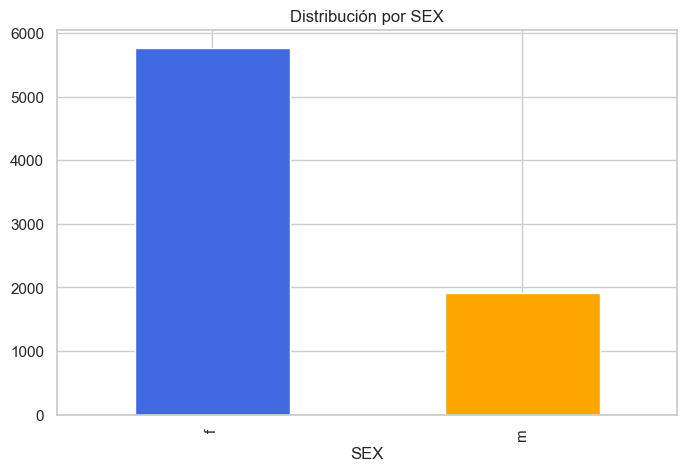


=== Estadísticas de AGE ===
count     7675
unique     142
top          1
freq       156
Name: AGE, dtype: object


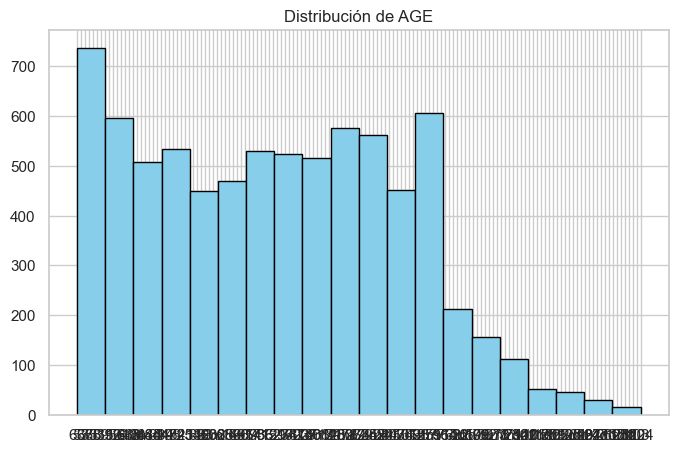


=== ESBL (+/-) ===
ESBL
-      6545
+      1120
NaN      10
Name: count, dtype: int64


C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='ESBL', palette='Set2')


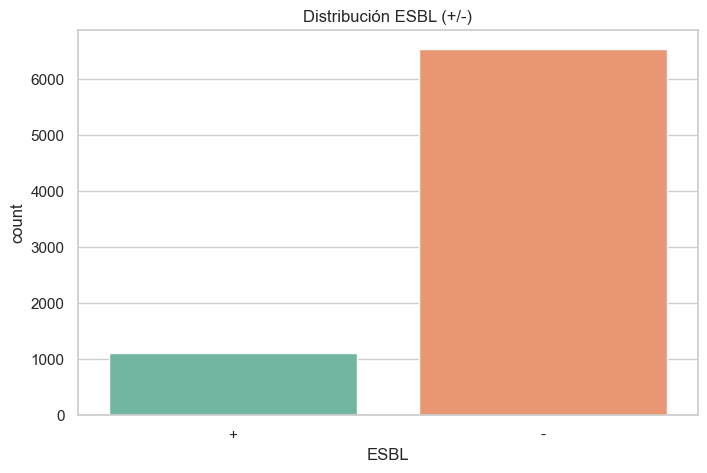


=== Descripción MIC ===


,AMK_NM,AMP_NM,SAM_NM,FEP_NM,CTX_NM,CAZ_NM,CRO_NM,CXM_NM,CXA_NM,CEP_NM,CIP_NM,ETP_NM,FOS_NM,GEN_NM,MEM_NM,NIT_NM,NOR_NM,TZP_NM
count,7658.000000,3928.000000,7668.000000,7649.000000,902.000000,7662.000000,4769.000000,862.000000,862.000000,1716.000000,7662.000000,7648.000000,1737.000000,4771.000000,7666.000000,4764.000000,1739.000000,5883.000000
mean,2.564247,20.532841,13.406364,2.088890,7.547672,4.006346,8.805934,11.676334,11.676334,18.517483,1.389638,0.321206,18.818653,3.147349,0.266273,21.390428,4.595170,8.508584
std,2.107001,14.159103,12.355257,7.510332,18.927851,11.007187,20.490133,19.511297,19.511297,20.129211,1.725028,0.267231,23.870907,5.217038,0.438472,32.246185,6.471701,19.764881
min,1.000000,1.000000,2.000000,0.120000,1.000000,0.120000,0.250000,1.000000,1.000000,2.000000,0.060000,0.120000,16.000000,1.000000,0.250000,16.000000,0.500000,4.000000
25%,2.000000,2.000000,2.000000,0.120000,1.000000,0.120000,1.000000,4.000000,4.000000,4.000000,0.250000,0.120000,16.000000,1.000000,0.250000,16.000000,0.500000,4.000000
50%,2.000000,32.000000,8.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,8.000000,0.250000,0.500000,16.000000,1.000000,0.250000,16.000000,0.500000,4.000000
75%,2.000000,32.000000,32.000000,1.000000,1.000000,2.000000,1.000000,4.000000,4.000000,16.000000,4.000000,0.500000,16.000000,1.000000,0.250000,16.000000,8.000000,4.000000
max,64.000000,64.000000,32.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,4.000000,8.000000,256.000000,16.000000,16.000000,512.000000,16.000000,128.000000


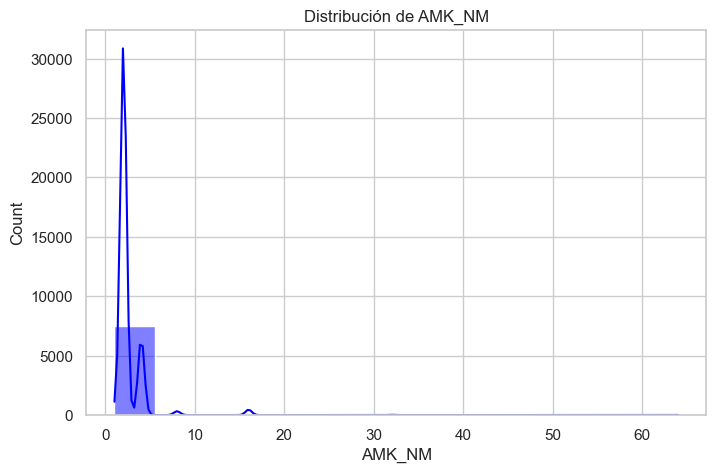

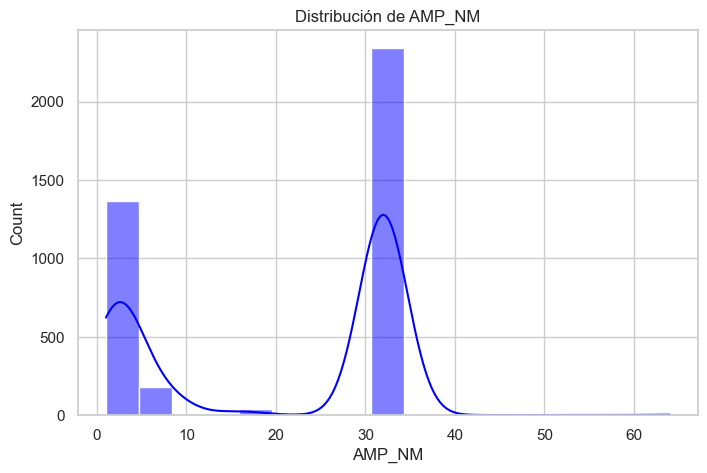

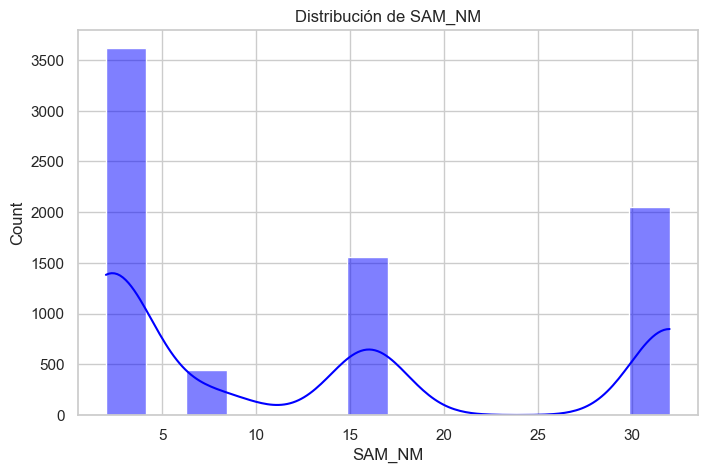

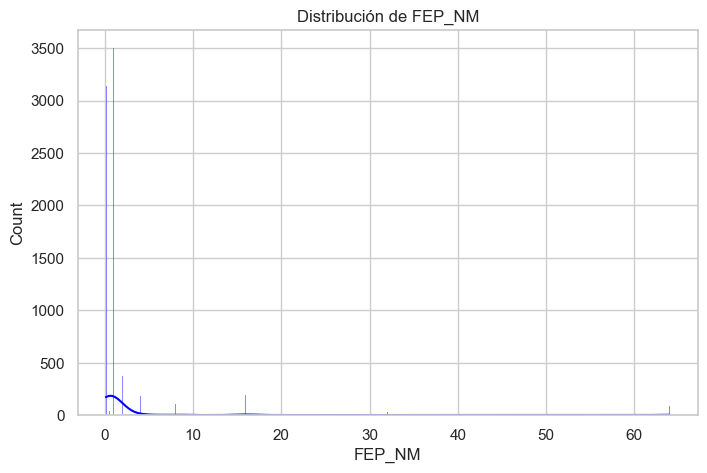

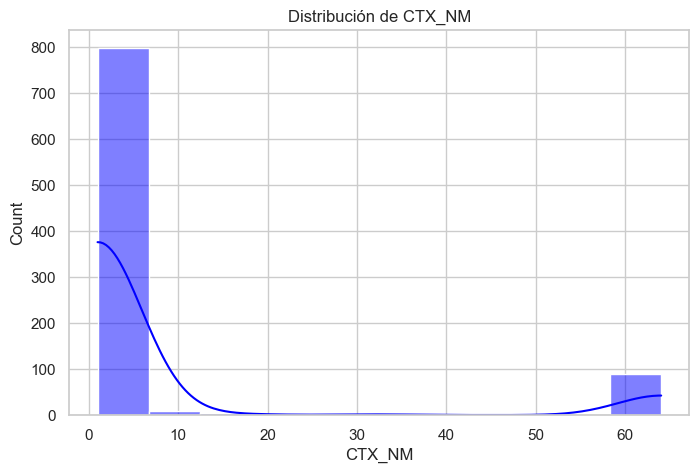

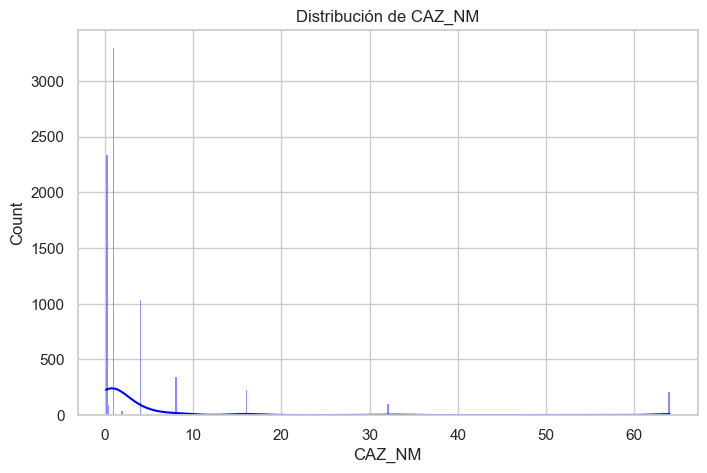

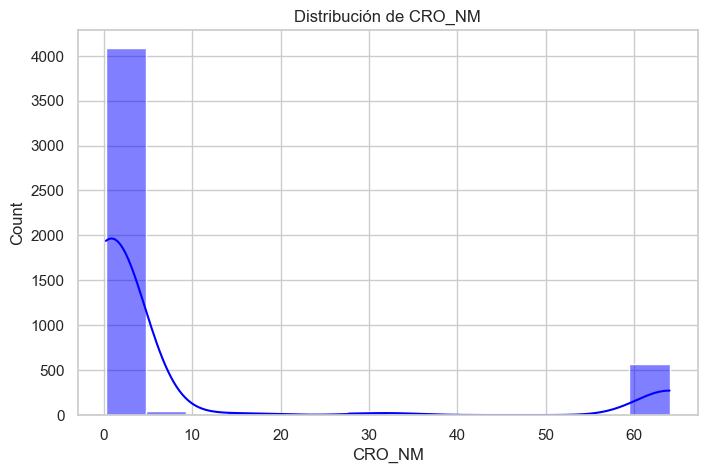

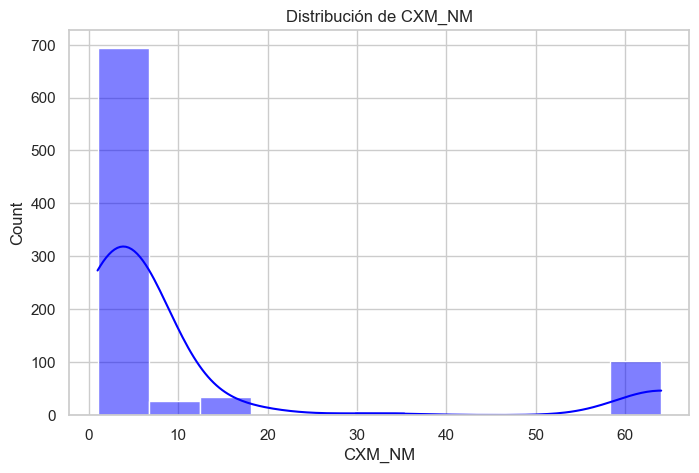

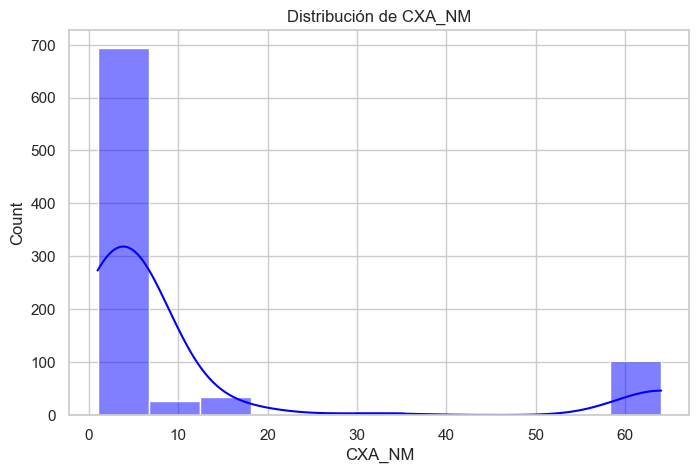

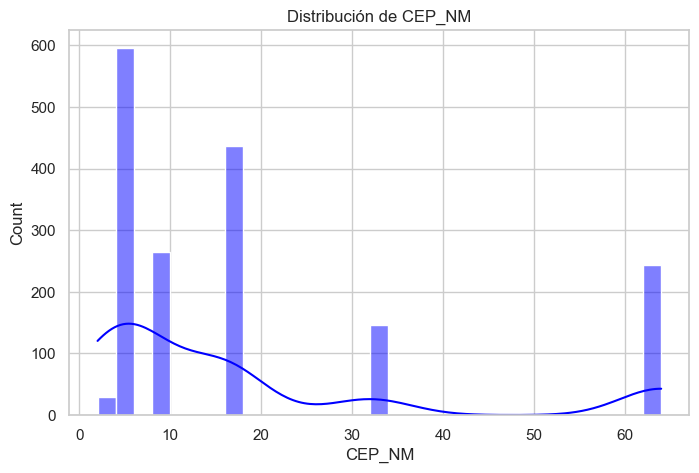

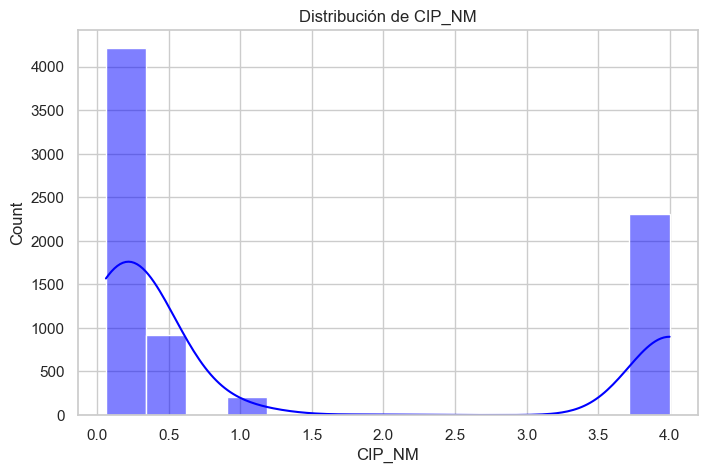

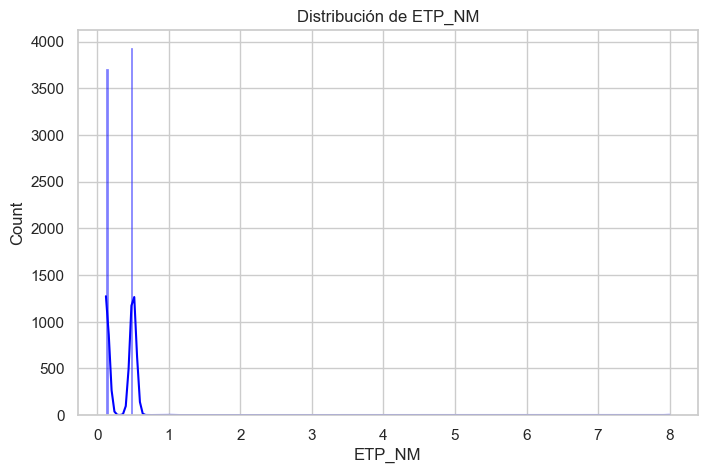

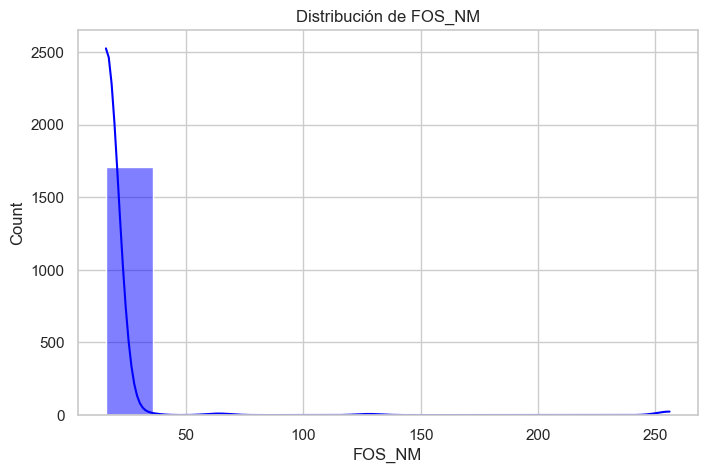

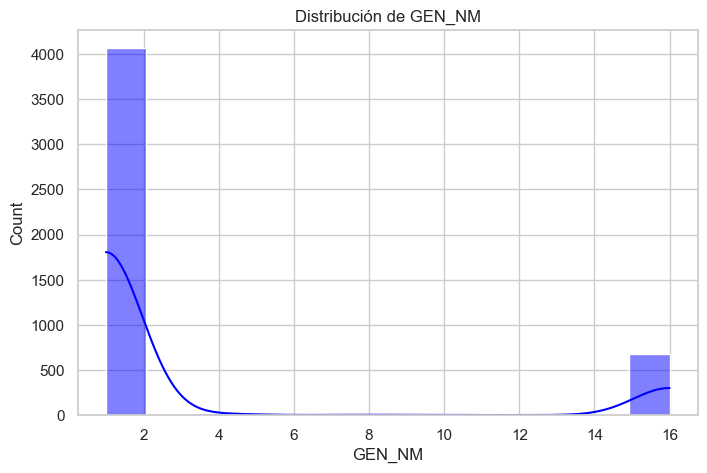

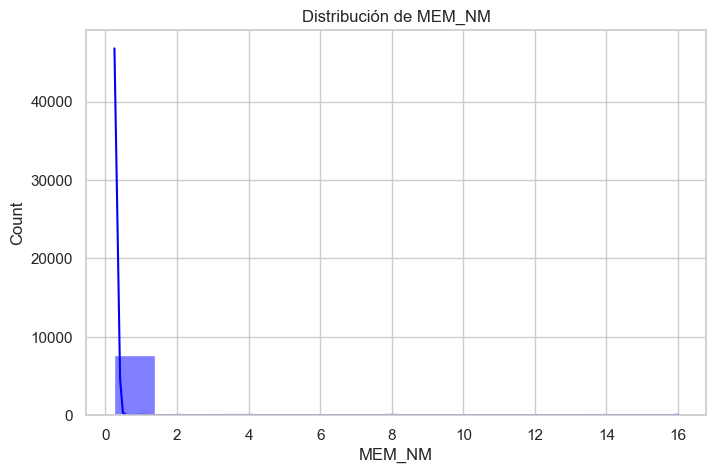

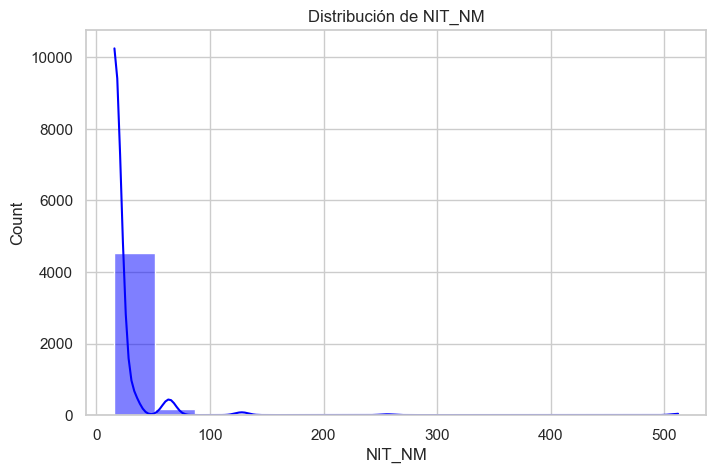

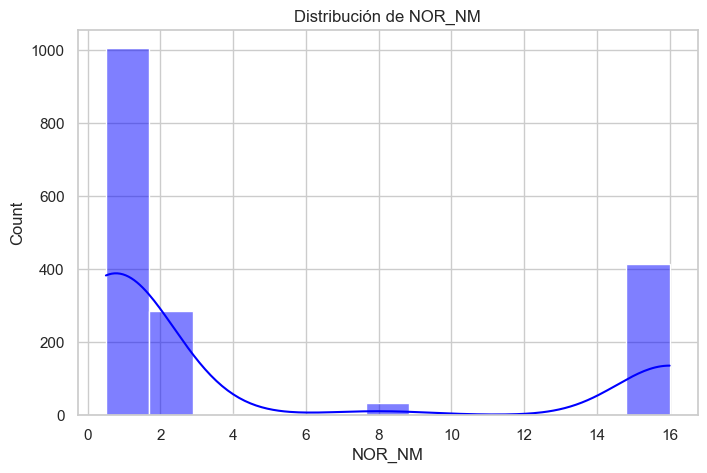

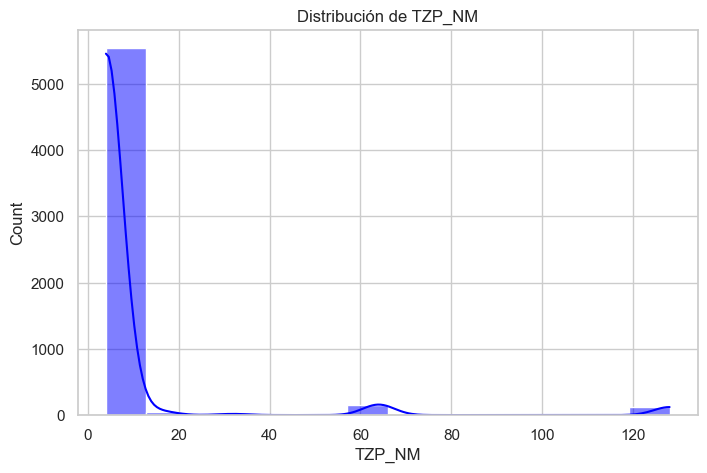

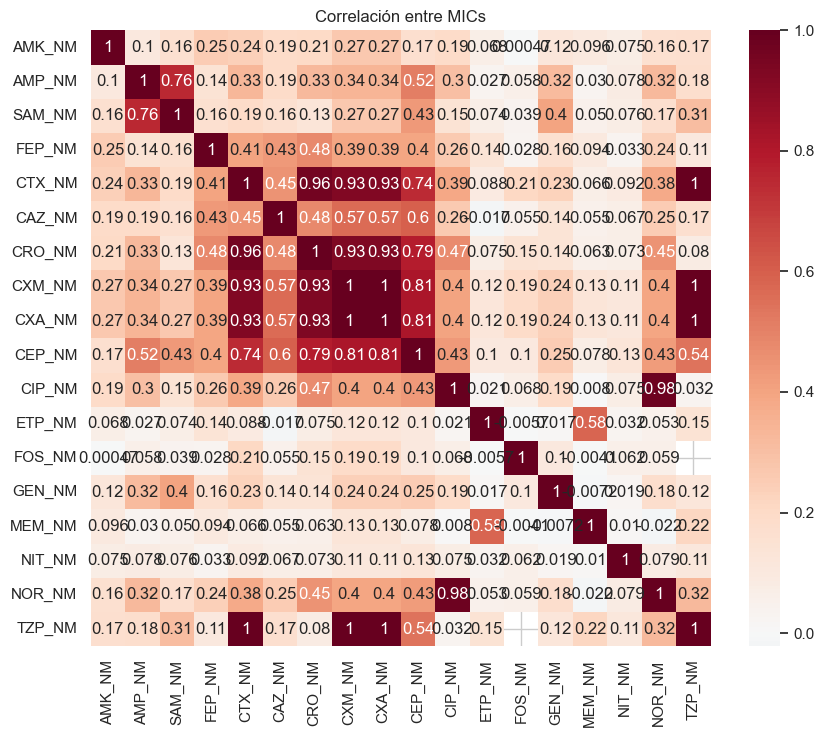

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


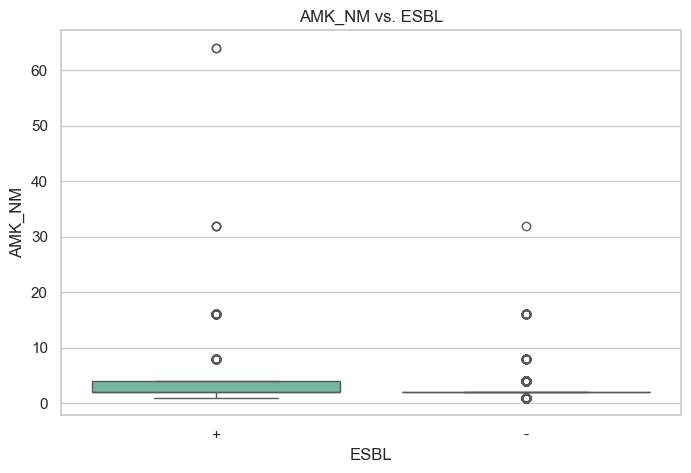

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


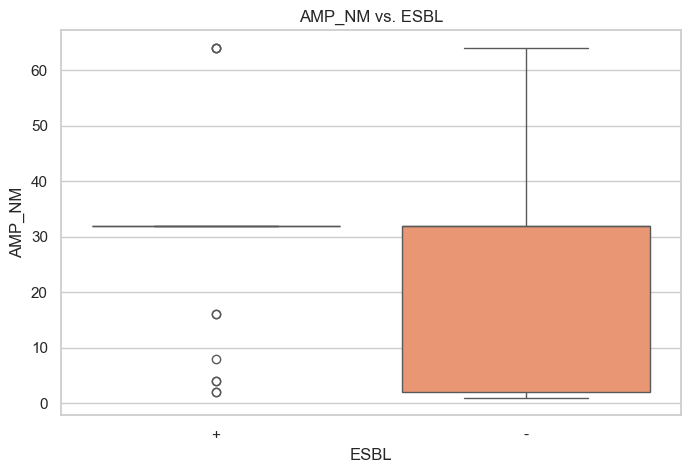

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


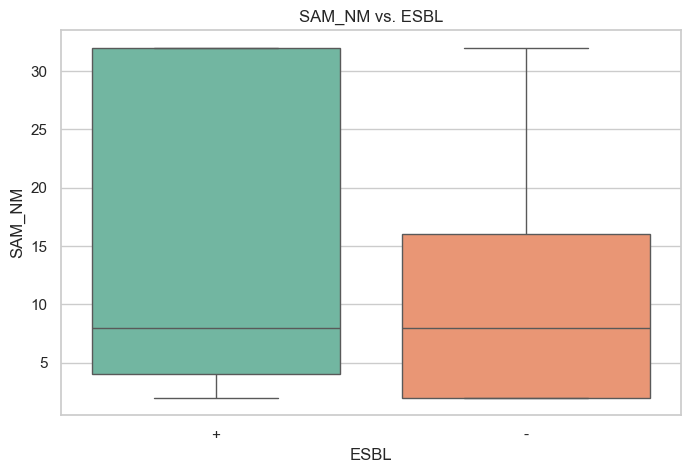

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


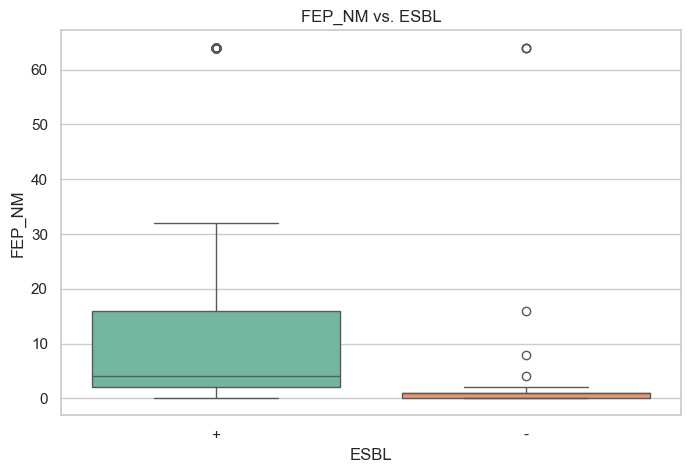

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


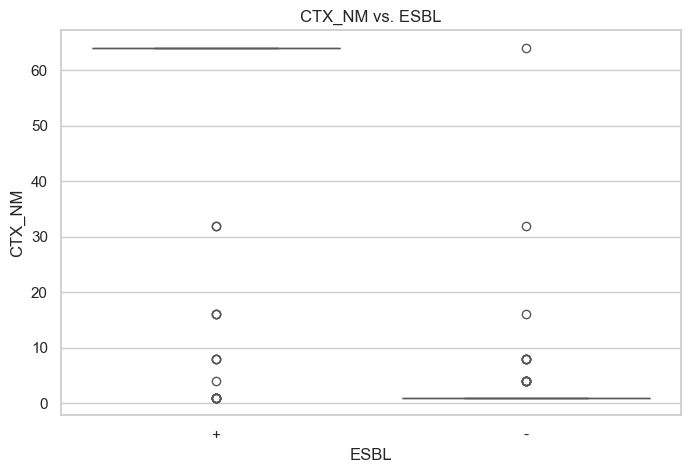

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


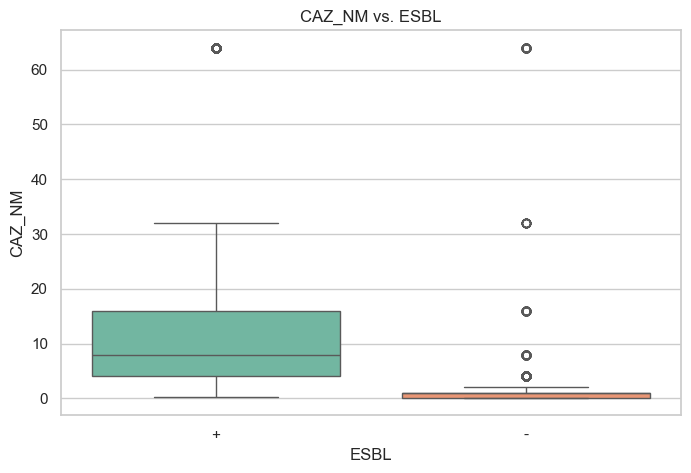

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


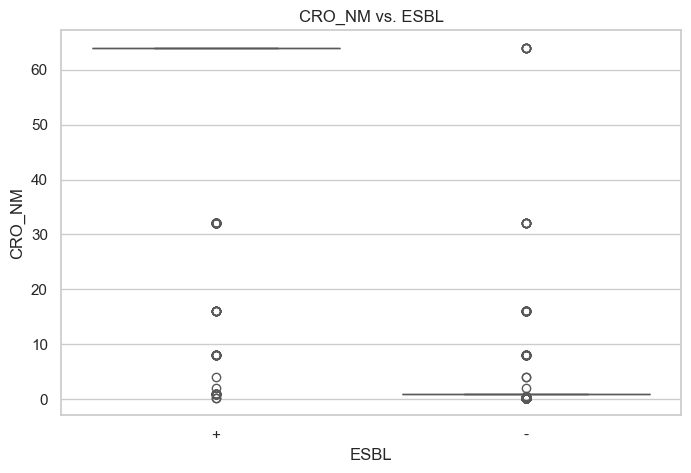

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


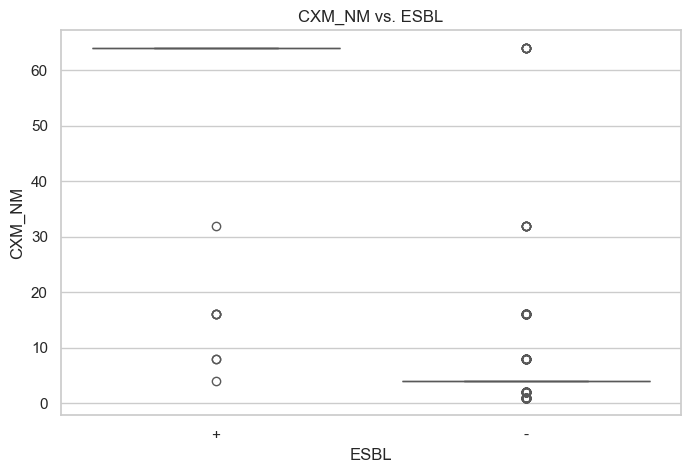

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


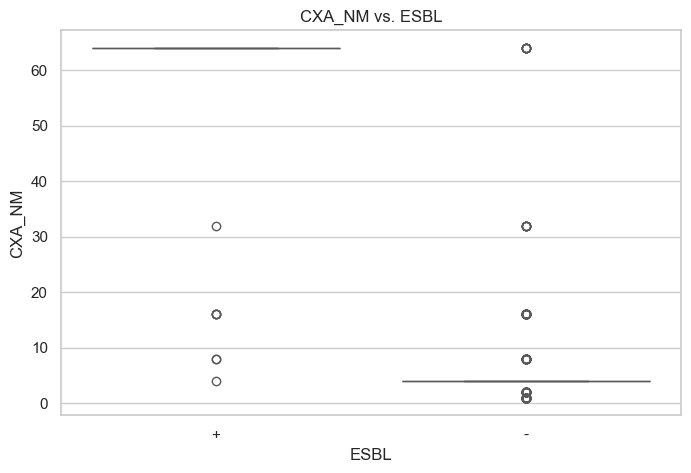

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


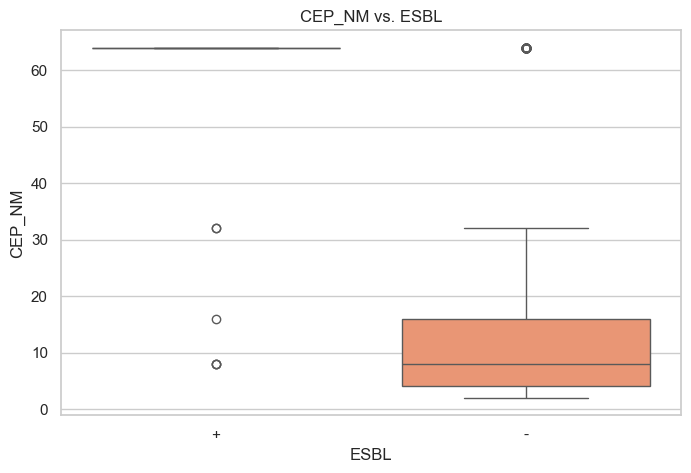

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


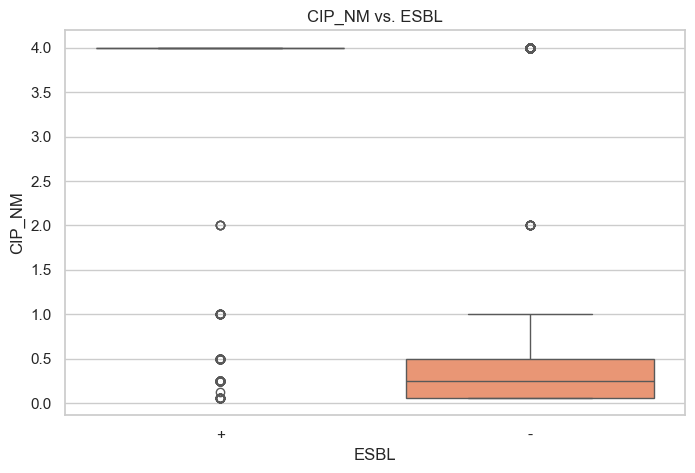

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


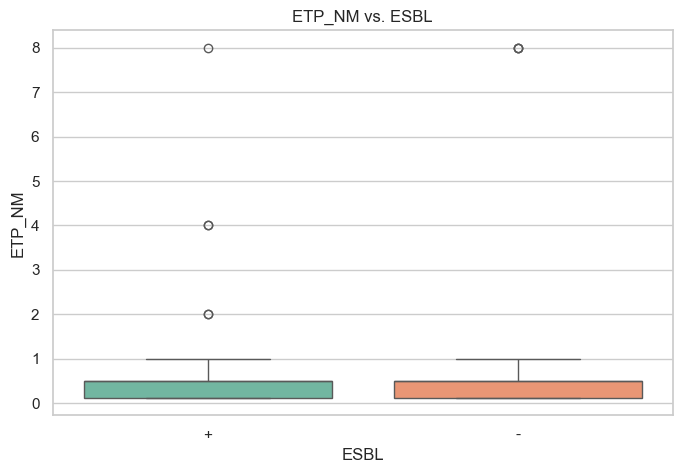

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


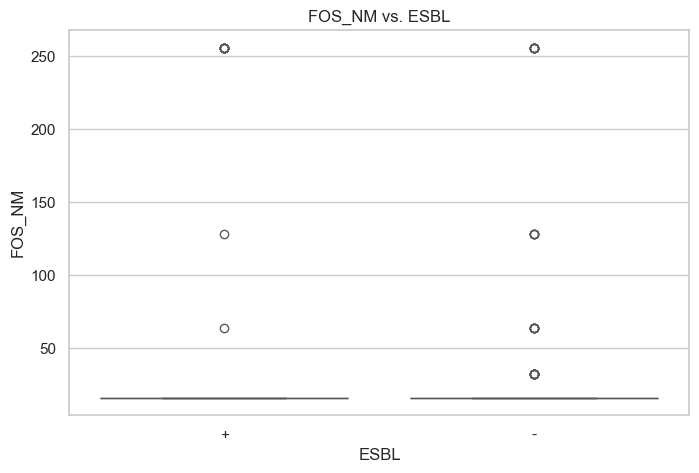

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


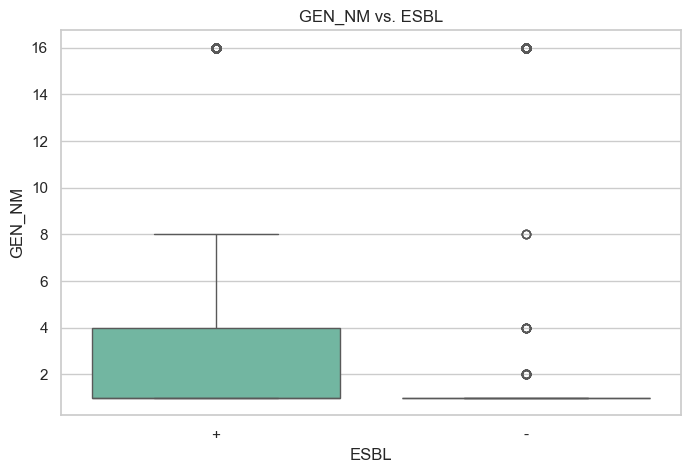

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


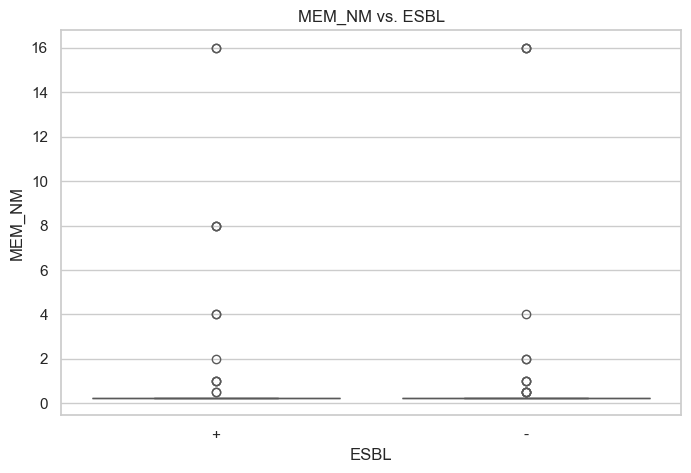

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


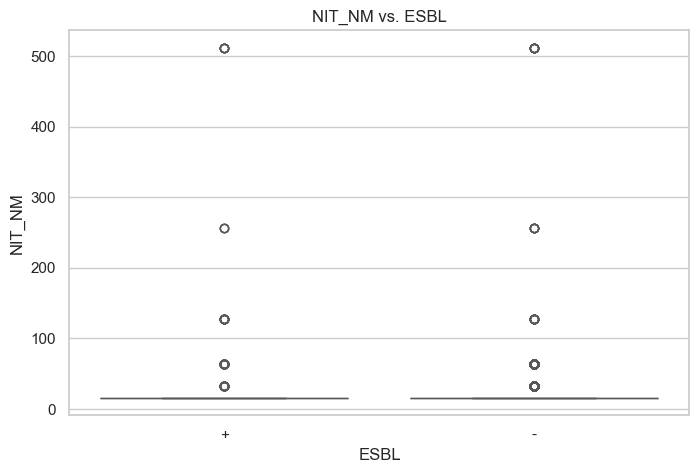

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


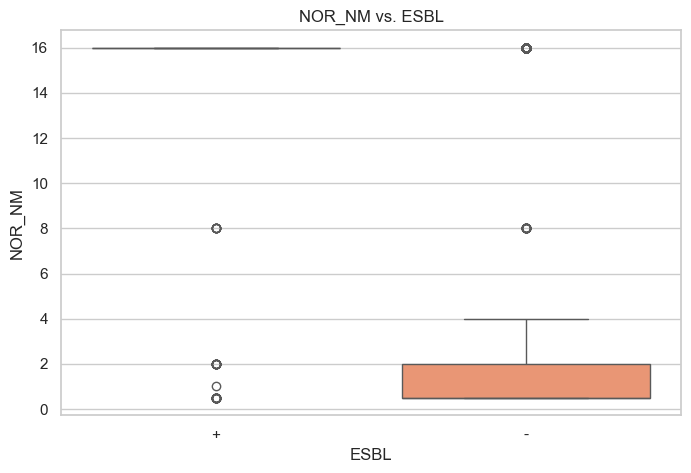

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\3454571336.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')


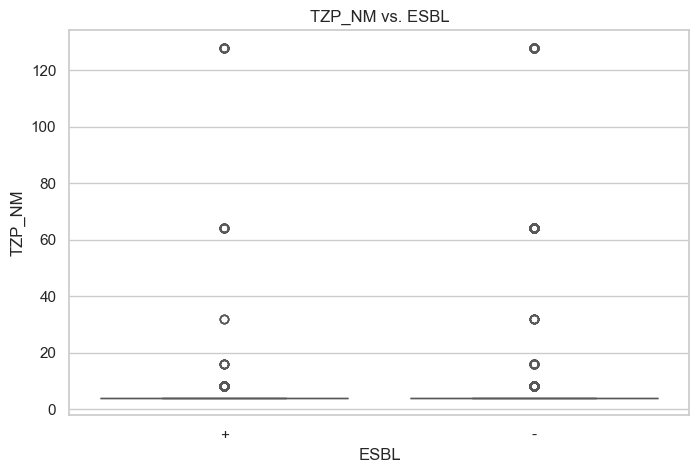


=== FIN ANÁLISIS DESCRIPTIVO ===


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# 1. Carga de datos

# 2. Visión general
print(df.shape)
display(df.head())
df.info()

# 3. Descriptivo de variables clave
print("\n=== Distribución SEX ===")
print(df['SEX'].value_counts(dropna=False))

plt.figure()
df['SEX'].value_counts(dropna=False).plot(kind='bar', color=['royalblue', 'orange'])
plt.title("Distribución por SEX")
plt.show()

print("\n=== Estadísticas de AGE ===")
print(df['AGE'].describe())

plt.figure()
plt.hist(df['AGE'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title("Distribución de AGE")
plt.show()

# 4. ESBL
print("\n=== ESBL (+/-) ===")
print(df['ESBL'].value_counts(dropna=False))

sns.countplot(data=df, x='ESBL', palette='Set2')
plt.title("Distribución ESBL (+/-)")
plt.show()

# 5. Enzimas / MIC
mic_cols = [
    'AMK_NM','AMP_NM','SAM_NM','FEP_NM','CTX_NM','CAZ_NM','CRO_NM',
    'CXM_NM','CXA_NM','CEP_NM','CIP_NM','ETP_NM','FOS_NM','GEN_NM',
    'MEM_NM','NIT_NM','NOR_NM','TZP_NM'
]
mic_present = [c for c in mic_cols if c in df.columns]

print("\n=== Descripción MIC ===")
display(df[mic_present].describe())

# Histograma para cada MIC
for col in mic_present:
    plt.figure()
    sns.histplot(data=df, x=col, kde=True, color='blue')
    plt.title(f"Distribución de {col}")
    plt.show()

# Correlación
corr_matrix = df[mic_present].corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title("Correlación entre MICs")
plt.show()

# Boxplot MIC vs ESBL
for col in mic_present:
    plt.figure()
    sns.boxplot(x='ESBL', y=col, data=df, palette='Set2')
    plt.title(f"{col} vs. ESBL")
    plt.show()

print("\n=== FIN ANÁLISIS DESCRIPTIVO ===")



=== Columnas originales ===
['PATIENT_ID,C,12', 'SEX,C,1', 'DATE_BIRTH,D', 'AGE,C,3', 'WARD,C,6', 'SPEC_DATE,D', 'SPEC_TYPE,C,2', 'ORGANISM,C,3', 'ESBL,C,1', 'CARBAPENEM,C,1', 'X_IAD,C,7', 'X_APB,C,7', 'X_EDTA,C,3', 'X_THM,C,3', 'X_ISO,C,6', 'X_CARBA_NP,C,10', 'X_XPERT,C,1', 'X_MCIM,C,1', 'X_ECIM,C,1', 'X_GEN_CARB,C,7', 'X_ICR,C,10', 'X_OXSF,C,10', 'X_VIGILANC,C,10', 'X_HODGE,C,10', 'NOSOCOMIAL,C,10', 'X_CARB_NP,C,10', 'AMK_NM,C,6', 'AMB_NM,C,6', 'AMP_NM,C,6', 'SAM_NM,C,6', 'ATM_NM,C,6', 'CAS_NM,C,6', 'CZO_NM,C,6', 'FEP_NM,C,6', 'CTX_NM,C,6', 'FOX_NM,C,6', 'CAZ_NM,C,6', 'CRO_NM,C,6', 'CXM_NM,C,6', 'CXA_NM,C,6', 'CEP_NM,C,6', 'CIP_NM,C,6', 'CLI_NM,C,6', 'COL_NM,C,6', 'DOR_NM,C,6', 'ETP_NM,C,6', 'ERY_NM,C,6', 'FLU_NM,C,6', 'FOS_NM,C,6', 'GEN_NM,C,6', 'GEH_NM,C,6', 'IPM_NM,C,6', 'LVX_NM,C,6', 'LNZ_NM,C,6', 'MEM_NM,C,6', 'MIF_NM,C,6', 'MNO_NM,C,6', 'MFX_NM,C,6', 'NIT_NM,C,6', 'NOR_NM,C,6', 'OXA_NM,C,6', 'TZP_NM,C,6', 'QDA_NM,C,6', 'RIF_NM,C,6', 'STH_NM,C,6', 'TEC_NM,C,6', 'TCY_NM,C,6', 'T

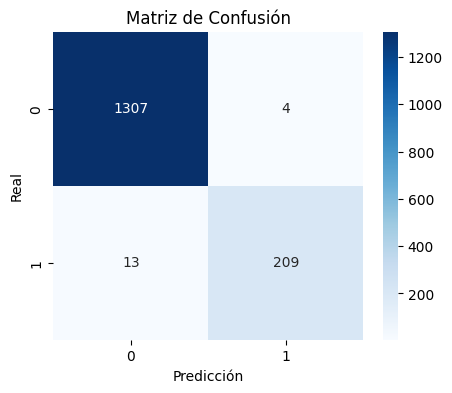

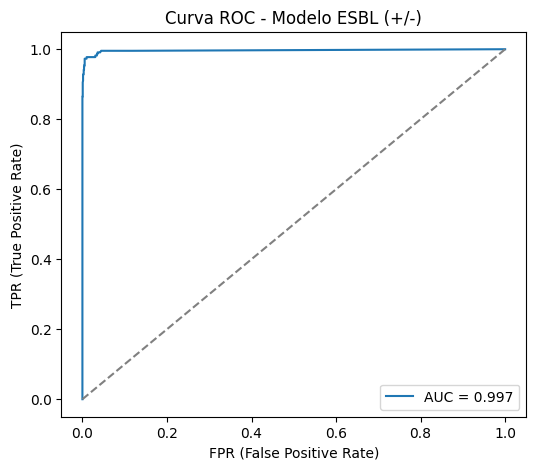

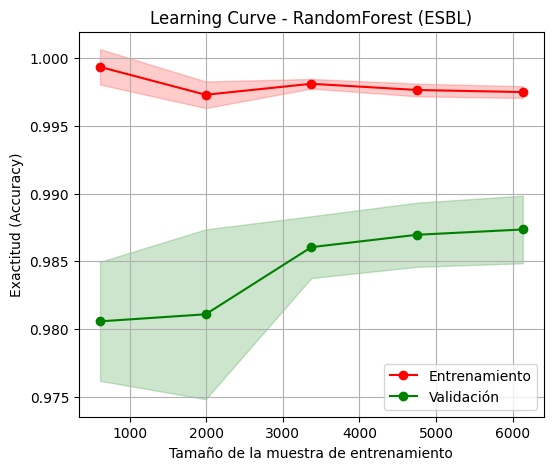


=== IMPORTANCIA DE LAS CARACTERÍSTICAS ===
FEP_NM    0.399688
CRO_NM    0.204139
CAZ_NM    0.190754
CIP_NM    0.052392
SAM_NM    0.028725
CEP_NM    0.022994
AMK_NM    0.016781
TZP_NM    0.012831
AMP_NM    0.010450
NOR_NM    0.009208
NIT_NM    0.009026
CTX_NM    0.008471
ETP_NM    0.008359
GEN_NM    0.005722
CXA_NM    0.005489
CXM_NM    0.005243
MEM_NM    0.004971
FOS_NM    0.004755
dtype: float64


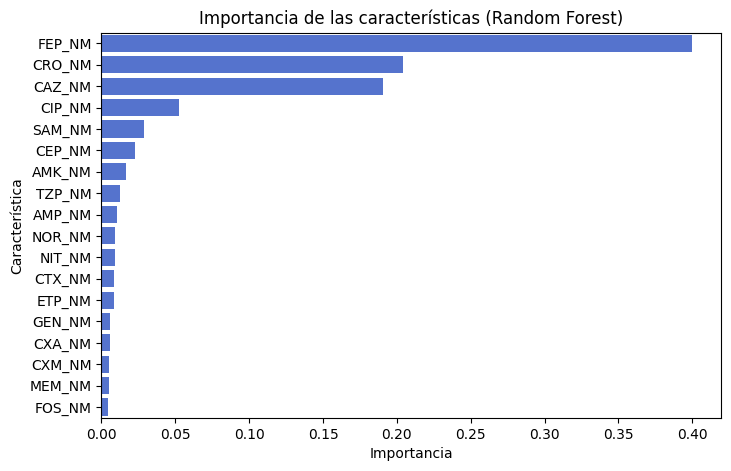


=== EJECUCIÓN TERMINADA ===


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score)

##############################################################################
# 1. LECTURA DE DATOS
##############################################################################

excel_file = "datos_ecoli.xlsx"  # Ajusta nombre/ruta según tu archivo
df = pd.read_excel(excel_file, sheet_name=0)  # Lee la primera hoja (sheet=0)

print("\n=== Columnas originales ===")
print(df.columns.tolist())

##############################################################################
# 2. ARREGLAR EL NOMBRE DE LAS COLUMNAS
# (Quitar cosas como ',C,10' o ',D' que van tras la primera coma)
##############################################################################

# Creamos nuevos nombres de columnas tomando SOLO lo previo a la primera coma
new_col_names = []
for col in df.columns:
    # Dividir la cadena por la primera coma y quedarse con la primera parte
    clean_name = col.split(',', 1)[0]
    new_col_names.append(clean_name)

df.columns = new_col_names

print("\n=== Columnas luego de limpiarlas ===")
print(df.columns.tolist())

##############################################################################
# 3. FUNCIÓN PARA PARSEAR VALORES MIC (opcional)
#    Si tienes datos como '<=2', '>16', etc., conviértelos a un valor numérico.
##############################################################################

def parse_mic(value):
    """
    Convierte valores con símbolos <= o > a un número flotante.
    Ejemplo: '<=2' -> 2.0, '>16' -> 32.0
    Ajusta la lógica según tus cortes y criterio de laboratorio.
    """
    if pd.isnull(value) or str(value).strip() == '':
        return np.nan
    val_str = str(value).strip().lower()

    if val_str.startswith('<='):
        try:
            return float(val_str.replace('<=',''))
        except:
            return np.nan
    elif val_str.startswith('>'):
        try:
            base = float(val_str.replace('>',''))
            # Ejemplo: multiplicar por 2 para marcar que está por encima
            return base * 2
        except:
            return np.nan
    else:
        try:
            return float(val_str)
        except:
            return np.nan

##############################################################################
# 4. SELECCIONAR COLUMNAS DE INTERÉS (las mencionadas)
##############################################################################

cols_enzimas = [
    "AMK_NM","AMP_NM","SAM_NM","FEP_NM","CTX_NM","CAZ_NM","CRO_NM",
    "CXM_NM","CXA_NM","CEP_NM","CIP_NM","ETP_NM","FOS_NM","GEN_NM",
    "MEM_NM","NIT_NM","NOR_NM","TZP_NM"
]

# Ver cuáles de esas columnas existen en el DataFrame limpio
cols_presentes = [c for c in cols_enzimas if c in df.columns]
print(f"\nColumnas de interés presentes en el DataFrame: {cols_presentes}")

# (Opcional) Parsear dichas columnas si tienen el formato <=, >
for c in cols_presentes:
    df[c] = df[c].apply(parse_mic)

##############################################################################
# 5. PREPARAR VARIABLE OBJETIVO (ESBL) => binaria
##############################################################################

if "ESBL" not in df.columns:
    raise ValueError("No se encontró la columna 'ESBL' en el DataFrame (ya limpia).")
    
# Convertimos "+"/"-" a 1/0
df["ESBL_bin"] = df["ESBL"].map({"+": 1, "-": 0})
df = df.dropna(subset=["ESBL_bin"])  # Quita filas donde ESBL_bin sea NaN

##############################################################################
# 6. CONSTRUIR MATRIZ X, y PARA EL MODELO
##############################################################################

X = df[cols_presentes].copy()  # Features
y = df["ESBL_bin"].copy()      # Objetivo

# Rellenar valores faltantes con la media de cada columna (forma sencilla)
X = X.fillna(X.mean())

##############################################################################
# 7. ENTRENAR MODELO (Random Forest) Y EVALUAR
##############################################################################

# Partir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]  # Probabilidades de la clase 1

# Matriz de confusión y reporte de clasificación
cm = confusion_matrix(y_test, y_pred)

print("\n=== MATRIZ DE CONFUSIÓN ===")
print(cm)

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred))

# Graficar la matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Curva ROC - Modelo ESBL (+/-)")
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.show()

##############################################################################
# 8. LEARNING CURVE (evolución con tamaño de entrenamiento)
##############################################################################

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(6,5))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento")
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.2, color="r")

plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validación")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.2, color="g")

plt.title("Learning Curve - RandomForest (ESBL)")
plt.xlabel("Tamaño de la muestra de entrenamiento")
plt.ylabel("Exactitud (Accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

##############################################################################
# 9. IMPORTANCIA DE VARIABLES
##############################################################################

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=cols_presentes).sort_values(ascending=False)

print("\n=== IMPORTANCIA DE LAS CARACTERÍSTICAS ===")
print(feat_imp)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp, y=feat_imp.index, color='royalblue')
plt.title("Importancia de las características (Random Forest)")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

##############################################################################
# FIN
##############################################################################

print("\n=== EJECUCIÓN TERMINADA ===")


### Serie de tiempo

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\1523255296.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_res = df.resample('M')['CIP_resistant'].mean()  # Promedio (tasa)


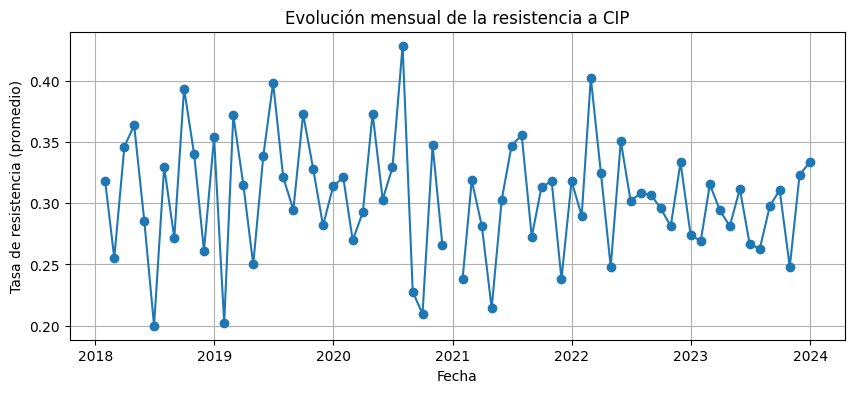

C:\Users\JUAN BERNAL\AppData\Local\Temp\ipykernel_13596\1523255296.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_res.fillna(method='ffill', inplace=True)  # rellena NaN


                               SARIMAX Results                                
Dep. Variable:          CIP_resistant   No. Observations:                   72
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 118.627
Date:                Fri, 31 Jan 2025   AIC                           -229.254
Time:                        09:19:55   BIC                           -220.148
Sample:                    01-31-2018   HQIC                          -225.629
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3039      0.004     71.840      0.000       0.296       0.312
ar.L1          0.2695      0.524      0.514      0.607      -0.758       1.297
ma.L1         -0.4481      0.468     -0.958      0.3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Usando el mismo df, asumimos que ya está con nombres limpios
# Asegúrate de que 'SPEC_DATE' sea un tipo fecha:
df['SPEC_DATE'] = pd.to_datetime(df['SPEC_DATE'], errors='coerce')

# Crear una columna binaria: CIP_resistant
# (Ejemplo de punto de corte CIP: 1 mg/L, ajusta según guías)
cutoff_cip = 1.0
df['CIP_resistant'] = (df['CIP_NM'] > cutoff_cip).astype(int)

# Agrupar por mes y calcular la tasa de resistencia
df.set_index('SPEC_DATE', inplace=True)  # Convertir date en índice (facilita resample)
monthly_res = df.resample('M')['CIP_resistant'].mean()  # Promedio (tasa)

# Graficar esa serie
plt.figure(figsize=(10,4))
plt.plot(monthly_res.index, monthly_res.values, marker='o')
plt.title("Evolución mensual de la resistencia a CIP")
plt.xlabel("Fecha")
plt.ylabel("Tasa de resistencia (promedio)")
plt.grid(True)
plt.show()

# Modelo ARIMA (simple) con statsmodels
# (Necesita una serie univariada y un índice de tiempo)
monthly_res.fillna(method='ffill', inplace=True)  # rellena NaN
model = sm.tsa.ARIMA(monthly_res, order=(1,0,1))  # ARIMA(p,d,q)
results = model.fit()
print(results.summary())

# Predecir los próximos 3 meses, por ejemplo
forecast = results.get_forecast(steps=3)
print("\n=== Pronóstico 3 meses ===")
print(forecast.summary_frame())


## Serie de tiempo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1) Revisar cuántos datos válidos hay en cada columna (excepto 'SPEC_DATE', 'ESBL', etc.)
#    Ajusta la lista "posibles_cols" si quieres filtrar solo entre ciertas columnas.
posibles_cols = [col for col in df.columns if col.endswith("_NM") and col not in ["ESBL", "ESBL_bin"]]

conteo_no_nulos = df[posibles_cols].notnull().sum()
top5 = conteo_no_nulos.sort_values(ascending=False).head(5).index.tolist()

print("Las 5 columnas con más datos son:", top5)


Las 5 columnas con más datos son: ['SAM_NM', 'CIP_NM', 'MEM_NM', 'CAZ_NM', 'AMK_NM']


In [4]:
print(df.columns)

Index(['PATIENT_ID', 'SEX', 'DATE_BIRTH', 'AGE', 'WARD', 'SPEC_TYPE',
       'ORGANISM', 'ESBL', 'CARBAPENEM', 'X_IAD',
       ...
       'MUP_ND5', 'PEN_ND10', 'RIF_ND5', 'STH_ND300', 'TCY_ND30', 'TEC_ND30',
       'TGC_ND15', 'X_1_NM', 'ESBL_bin', 'CIP_resistant'],
      dtype='object', length=143)


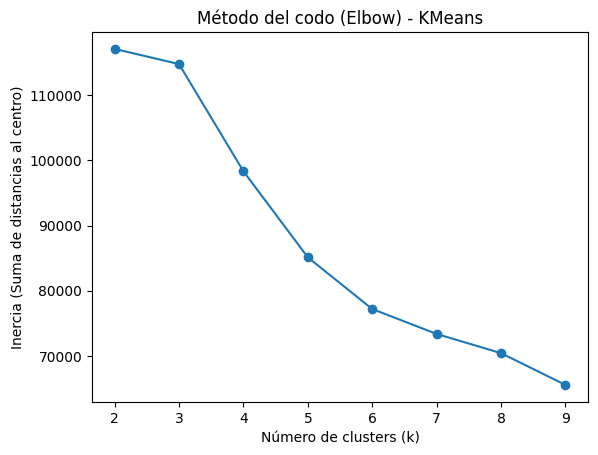

cluster
2    4239
0    3420
1       6
Name: count, dtype: int64


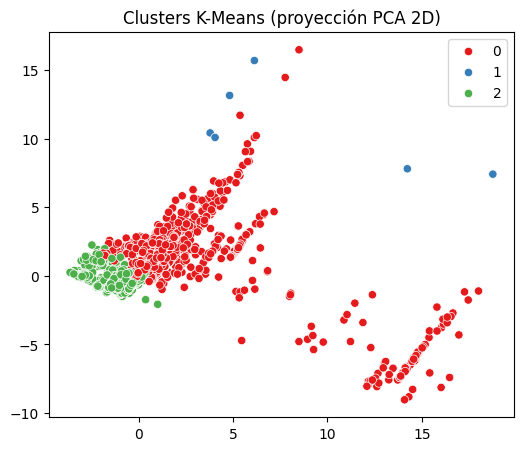

In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo df ya limpio, con las columnas MIC:
X = df[cols_presentes].copy()  # Reutilizar la lista 'cols_presentes'
X = X.fillna(X.mean())

# Opcional: Normalizar datos (MIC varía en rangos distintos)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elegir número de clusters (k). Podemos usar la "técnica del codo" o "silhouette".
inertias = []
K_range = range(2, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.title("Método del codo (Elbow) - KMeans")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Suma de distancias al centro)")
plt.show()

# Supongamos elegimos k=3
km = KMeans(n_clusters=3, random_state=42)
labels = km.fit_predict(X_scaled)

df['cluster'] = labels  # asignamos el cluster a cada muestra

# Análisis: ver cuántas muestras hay en cada cluster
print(df['cluster'].value_counts())

# Graficar alguna proyección con PCA 2D para visualizar clusters
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
sns.scatterplot(x=coords_2d[:,0], y=coords_2d[:,1], hue=labels, palette="Set1")
plt.title("Clusters K-Means (proyección PCA 2D)")
plt.show()


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score)

# Para la integración de Keras con Scikit-Learn:
!pip install scikeras  # Si no lo tienes instalado; o instalalo con conda
from scikeras.wrappers import KerasClassifier

# Para la búsqueda aleatoria de hiperparámetros:
from sklearn.model_selection import RandomizedSearchCV, KFold

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

##############################################################################
# 1. LECTURA DE DATOS
##############################################################################

excel_file = "datos_ecoli.xlsx"  # Ajusta la ruta/nombre según tu archivo
df = pd.read_excel(excel_file, sheet_name=0)

print("\n=== Columnas originales ===")
print(df.columns.tolist())

##############################################################################
# 2. ARREGLAR EL NOMBRE DE LAS COLUMNAS
##############################################################################

new_col_names = []
for col in df.columns:
    clean_name = col.split(',', 1)[0]
    new_col_names.append(clean_name)

df.columns = new_col_names

print("\n=== Columnas luego de limpiarlas ===")
print(df.columns.tolist())

##############################################################################
# 3. FUNCIÓN PARA PARSEAR VALORES MIC
##############################################################################

def parse_mic(value):
    """
    Convierte valores con símbolos <= o > a un número flotante.
    Ejemplo: '<=2' -> 2.0, '>16' -> 32.0
    Ajusta la lógica según tus cortes y criterio de laboratorio.
    """
    if pd.isnull(value) or str(value).strip() == '':
        return np.nan
    val_str = str(value).strip().lower()

    if val_str.startswith('<='):
        try:
            return float(val_str.replace('<=',''))
        except:
            return np.nan
    elif val_str.startswith('>'):
        try:
            base = float(val_str.replace('>',''))
            # Por ejemplo, multiplicar por 2 para marcar que está por encima
            return base * 2
        except:
            return np.nan
    else:
        try:
            return float(val_str)
        except:
            return np.nan

##############################################################################
# 4. SELECCIONAR COLUMNAS DE INTERÉS
##############################################################################

cols_enzimas = [
    "AMK_NM","AMP_NM","SAM_NM","FEP_NM","CTX_NM","CAZ_NM","CRO_NM",
    "CXM_NM","CXA_NM","CEP_NM","CIP_NM","ETP_NM","FOS_NM","GEN_NM",
    "MEM_NM","NIT_NM","NOR_NM","TZP_NM"
]

# Ver cuáles de esas columnas existen en el DataFrame
cols_presentes = [c for c in cols_enzimas if c in df.columns]
print(f"\nColumnas de interés presentes en el DataFrame: {cols_presentes}")

# Parsear dichas columnas
for c in cols_presentes:
    df[c] = df[c].apply(parse_mic)

##############################################################################
# 5. VARIABLE OBJETIVO (ESBL) binaria
##############################################################################

if "ESBL" not in df.columns:
    raise ValueError("No se encontró la columna 'ESBL' en el DataFrame.")

df["ESBL_bin"] = df["ESBL"].map({"+": 1, "-": 0})
df = df.dropna(subset=["ESBL_bin"])  # quitar filas donde ESBL_bin sea NaN

##############################################################################
# 6. MATRIZ X, y
##############################################################################

X = df[cols_presentes].copy()
y = df["ESBL_bin"].copy()

# Rellenar valores faltantes con la media de cada columna
X = X.fillna(X.mean())

##############################################################################
# 7. ENTRENAR/TEST SPLIT
##############################################################################

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# IMPORTANTE: Normalizar (StandardScaler) para NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

##############################################################################
# 8. DEFINIR FUNCIÓN QUE CONSTRUYA LA RED NEURONAL
##############################################################################
def create_model(
    num_neurons=64,
    num_layers=2,
    dropout_rate=0.2,
    learning_rate=1e-3,
    activation='relu'
):
    """
    Construye un modelo Keras MLP para clasificación binaria.
    Parámetros tunables:
        - num_neurons: número de neuronas en cada capa densa
        - num_layers: cuántas capas ocultas (Dense) usar
        - dropout_rate: tasa de dropout
        - learning_rate: tasa de aprendizaje
        - activation: función de activación ('relu', 'tanh', etc.)
    """

    model = models.Sequential()
    
    # Capa de entrada + primer hidden
    model.add(layers.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(num_neurons, activation=activation))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    
    # Agregar capas ocultas adicionales
    for _ in range(num_layers - 1):
        model.add(layers.Dense(num_neurons, activation=activation))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    
    # Capa de salida binaria
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compilar
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, 
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

##############################################################################
# 9. BÚSQUEDA ALEATORIA DE HIPERPARÁMETROS (Opcional / Avanzado)
##############################################################################
# Usamos KerasClassifier (Scikeras) para integrar con RandomizedSearchCV

model_wrapper = KerasClassifier(
    model=create_model,
    epochs=50,       # se puede aumentar
    batch_size=32,   # se puede tunear
    verbose=0        # silencia el entrenamiento en pantalla
)

# Espacio de búsqueda para varios hiperparámetros:
param_distributions = {
    "model__num_neurons": [32, 64, 128],
    "model__num_layers": [1, 2, 3],
    "model__dropout_rate": [0.0, 0.2, 0.4],
    "model__learning_rate": [1e-3, 1e-4],
    "model__activation": ["relu", "tanh"]
}

# Configurar el random search
# n_iter controla cuántas configuraciones se prueban
cv = KFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=model_wrapper,
    param_distributions=param_distributions,
    n_iter=10,  # probar 10 configuraciones aleatorias (podrías ampliarlo)
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,  # usa todos los núcleos disponibles
    random_state=42,
    verbose=1   # para ver progreso
)

# Ajustar la búsqueda a los datos
random_search.fit(X_train_scaled, y_train)

print("\n=== Mejores hiperparámetros encontrados ===")
print(random_search.best_params_)
print(f"Mejor score de validación: {random_search.best_score_:.4f}")

# Modelo final
best_model = random_search.best_estimator_

##############################################################################
# 10. EVALUACIÓN EN TEST
##############################################################################

y_pred = best_model.predict(X_test_scaled)
# .predict_proba() retorna prob de clase 0 y 1, nos interesa la de la clase 1
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

cm = confusion_matrix(y_test, y_pred)
print("\n=== MATRIZ DE CONFUSIÓN ===")
print(cm)

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Curva ROC - Red Neuronal (ESBL)")
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.show()

# Matriz de confusión (heatmap)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Red Neuronal")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

##############################################################################
# 11. VER HISTORIA DE ENTRENAMIENTO CON EL MEJOR MODELO (opcional)
##############################################################################
# Para ver la curva de entrenamiento, necesitamos re-entrenar con "return_fit=True"

best_params = random_search.best_params_

# Creamos un nuevo clasificador con los mismos hiperparámetros, 
# pero que retorne la historia de entrenamiento
model_to_plot = KerasClassifier(
    model=create_model,
    epochs=50,
    batch_size=32,
    verbose=0,
    return_fit=True,  # para obtener el History object
    **{k.replace("model__", ""): v for k,v in best_params.items()}
)

# Entrenamos y obtenemos el History
history = model_to_plot.fit(X_train_scaled, y_train)

# Graficamos accuracy vs val_accuracy
hist = history.history_
plt.figure(figsize=(8,5))
plt.plot(hist['accuracy'], label='Entrenamiento')
plt.plot(hist['val_accuracy'], label='Validación')
plt.title("Evolución de Accuracy en Entrenamiento vs. Validación")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

##############################################################################
# 12. (Opcional) LEARNING CURVE ESPECÍFICA PARA RED NEURONAL
##############################################################################
# La learning curve en NN no siempre es trivial porque requiere re-entrenar
# muchas veces desde cero con distintos tamaños de entrenamiento.
# Se puede hacer con la misma función 'learning_curve' de scikit-learn,
# pero cada tramo implica un reentrenamiento.
#
# ATENCIÓN: puede ser muy lento dependiendo de la complejidad del modelo
# y el tamaño de datos.

train_sizes, train_scores, test_scores = learning_curve(
    best_model,             # Ojo: el best_model entrena con scikeras
    X_train_scaled, 
    y_train,
    cv=3,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento")
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.2, color="r")

plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validación")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.2, color="g")

plt.title("Learning Curve - Red Neuronal (ESBL)")
plt.xlabel("Tamaño de la muestra de entrenamiento")
plt.ylabel("Exactitud (Accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

print("\n=== EJECUCIÓN TERMINADA ===")



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\JUAN BERNAL\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^



=== Columnas originales ===
['PATIENT_ID,C,12', 'SEX,C,1', 'DATE_BIRTH,D', 'AGE,C,3', 'WARD,C,6', 'SPEC_DATE,D', 'SPEC_TYPE,C,2', 'ORGANISM,C,3', 'ESBL,C,1', 'CARBAPENEM,C,1', 'X_IAD,C,7', 'X_APB,C,7', 'X_EDTA,C,3', 'X_THM,C,3', 'X_ISO,C,6', 'X_CARBA_NP,C,10', 'X_XPERT,C,1', 'X_MCIM,C,1', 'X_ECIM,C,1', 'X_GEN_CARB,C,7', 'X_ICR,C,10', 'X_OXSF,C,10', 'X_VIGILANC,C,10', 'X_HODGE,C,10', 'NOSOCOMIAL,C,10', 'X_CARB_NP,C,10', 'AMK_NM,C,6', 'AMB_NM,C,6', 'AMP_NM,C,6', 'SAM_NM,C,6', 'ATM_NM,C,6', 'CAS_NM,C,6', 'CZO_NM,C,6', 'FEP_NM,C,6', 'CTX_NM,C,6', 'FOX_NM,C,6', 'CAZ_NM,C,6', 'CRO_NM,C,6', 'CXM_NM,C,6', 'CXA_NM,C,6', 'CEP_NM,C,6', 'CIP_NM,C,6', 'CLI_NM,C,6', 'COL_NM,C,6', 'DOR_NM,C,6', 'ETP_NM,C,6', 'ERY_NM,C,6', 'FLU_NM,C,6', 'FOS_NM,C,6', 'GEN_NM,C,6', 'GEH_NM,C,6', 'IPM_NM,C,6', 'LVX_NM,C,6', 'LNZ_NM,C,6', 'MEM_NM,C,6', 'MIF_NM,C,6', 'MNO_NM,C,6', 'MFX_NM,C,6', 'NIT_NM,C,6', 'NOR_NM,C,6', 'OXA_NM,C,6', 'TZP_NM,C,6', 'QDA_NM,C,6', 'RIF_NM,C,6', 'STH_NM,C,6', 'TEC_NM,C,6', 'TCY_NM,C,6', 'T

c:\Users\JUAN BERNAL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The KerasClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [15]:
pip install --upgrade scikit-learn scikeras


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ------------------------ --------------- 6.8/11.1 MB 42.0 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn para preprocesamiento y métricas
from sklearn.model_selection import train_test_split, learning_curve, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

In [19]:
excel_file = "datos_ecoli.xlsx"  # Ajusta la ruta/nombre según tu archivo
df = pd.read_excel(excel_file, sheet_name=0)

print("\n=== Columnas originales ===")
print(df.columns.tolist())

##############################################################################
# 2. ARREGLAR EL NOMBRE DE LAS COLUMNAS
##############################################################################

df.columns = [col.split(',', 1)[0] for col in df.columns]

print("\n=== Columnas luego de limpiarlas ===")
print(df.columns.tolist())

##############################################################################
# 3. FUNCIÓN PARA PARSEAR VALORES MIC
##############################################################################

def parse_mic(value):
    """
    Convierte valores con símbolos <= o > a un número flotante.
    """
    if pd.isnull(value) or str(value).strip() == '':
        return np.nan
    val_str = str(value).strip().lower()

    if val_str.startswith('<='):
        return float(val_str.replace('<=',''))
    elif val_str.startswith('>'):
        return float(val_str.replace('>','')) * 2
    else:
        return float(val_str)

##############################################################################
# 4. SELECCIONAR COLUMNAS DE INTERÉS
##############################################################################

cols_enzimas = [
    "AMK_NM","AMP_NM","SAM_NM","FEP_NM","CTX_NM","CAZ_NM","CRO_NM",
    "CXM_NM","CXA_NM","CEP_NM","CIP_NM","ETP_NM","FOS_NM","GEN_NM",
    "MEM_NM","NIT_NM","NOR_NM","TZP_NM"
]

cols_presentes = [c for c in cols_enzimas if c in df.columns]
print(f"\nColumnas de interés presentes en el DataFrame: {cols_presentes}")


=== Columnas originales ===
['PATIENT_ID,C,12', 'SEX,C,1', 'DATE_BIRTH,D', 'AGE,C,3', 'WARD,C,6', 'SPEC_DATE,D', 'SPEC_TYPE,C,2', 'ORGANISM,C,3', 'ESBL,C,1', 'CARBAPENEM,C,1', 'X_IAD,C,7', 'X_APB,C,7', 'X_EDTA,C,3', 'X_THM,C,3', 'X_ISO,C,6', 'X_CARBA_NP,C,10', 'X_XPERT,C,1', 'X_MCIM,C,1', 'X_ECIM,C,1', 'X_GEN_CARB,C,7', 'X_ICR,C,10', 'X_OXSF,C,10', 'X_VIGILANC,C,10', 'X_HODGE,C,10', 'NOSOCOMIAL,C,10', 'X_CARB_NP,C,10', 'AMK_NM,C,6', 'AMB_NM,C,6', 'AMP_NM,C,6', 'SAM_NM,C,6', 'ATM_NM,C,6', 'CAS_NM,C,6', 'CZO_NM,C,6', 'FEP_NM,C,6', 'CTX_NM,C,6', 'FOX_NM,C,6', 'CAZ_NM,C,6', 'CRO_NM,C,6', 'CXM_NM,C,6', 'CXA_NM,C,6', 'CEP_NM,C,6', 'CIP_NM,C,6', 'CLI_NM,C,6', 'COL_NM,C,6', 'DOR_NM,C,6', 'ETP_NM,C,6', 'ERY_NM,C,6', 'FLU_NM,C,6', 'FOS_NM,C,6', 'GEN_NM,C,6', 'GEH_NM,C,6', 'IPM_NM,C,6', 'LVX_NM,C,6', 'LNZ_NM,C,6', 'MEM_NM,C,6', 'MIF_NM,C,6', 'MNO_NM,C,6', 'MFX_NM,C,6', 'NIT_NM,C,6', 'NOR_NM,C,6', 'OXA_NM,C,6', 'TZP_NM,C,6', 'QDA_NM,C,6', 'RIF_NM,C,6', 'STH_NM,C,6', 'TEC_NM,C,6', 'TCY_NM,C,6', 'T


=== Columnas originales ===
['PATIENT_ID,C,12', 'SEX,C,1', 'DATE_BIRTH,D', 'AGE,C,3', 'WARD,C,6', 'SPEC_DATE,D', 'SPEC_TYPE,C,2', 'ORGANISM,C,3', 'ESBL,C,1', 'CARBAPENEM,C,1', 'X_IAD,C,7', 'X_APB,C,7', 'X_EDTA,C,3', 'X_THM,C,3', 'X_ISO,C,6', 'X_CARBA_NP,C,10', 'X_XPERT,C,1', 'X_MCIM,C,1', 'X_ECIM,C,1', 'X_GEN_CARB,C,7', 'X_ICR,C,10', 'X_OXSF,C,10', 'X_VIGILANC,C,10', 'X_HODGE,C,10', 'NOSOCOMIAL,C,10', 'X_CARB_NP,C,10', 'AMK_NM,C,6', 'AMB_NM,C,6', 'AMP_NM,C,6', 'SAM_NM,C,6', 'ATM_NM,C,6', 'CAS_NM,C,6', 'CZO_NM,C,6', 'FEP_NM,C,6', 'CTX_NM,C,6', 'FOX_NM,C,6', 'CAZ_NM,C,6', 'CRO_NM,C,6', 'CXM_NM,C,6', 'CXA_NM,C,6', 'CEP_NM,C,6', 'CIP_NM,C,6', 'CLI_NM,C,6', 'COL_NM,C,6', 'DOR_NM,C,6', 'ETP_NM,C,6', 'ERY_NM,C,6', 'FLU_NM,C,6', 'FOS_NM,C,6', 'GEN_NM,C,6', 'GEH_NM,C,6', 'IPM_NM,C,6', 'LVX_NM,C,6', 'LNZ_NM,C,6', 'MEM_NM,C,6', 'MIF_NM,C,6', 'MNO_NM,C,6', 'MFX_NM,C,6', 'NIT_NM,C,6', 'NOR_NM,C,6', 'OXA_NM,C,6', 'TZP_NM,C,6', 'QDA_NM,C,6', 'RIF_NM,C,6', 'STH_NM,C,6', 'TEC_NM,C,6', 'TCY_NM,C,6', 'T

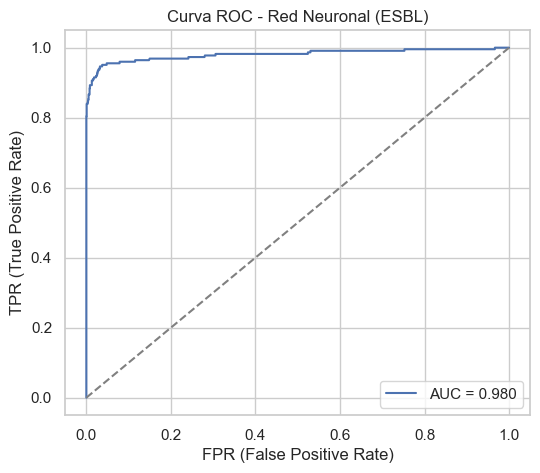

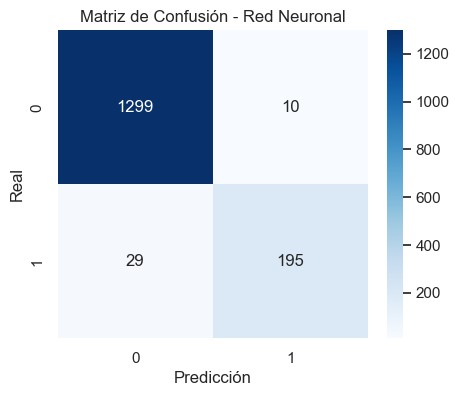

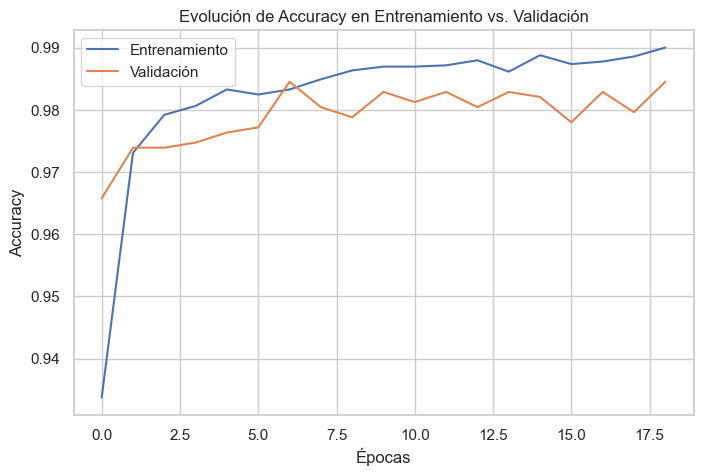

Entrenando con 10% de los datos...
Entrenando con 32% de los datos...
Entrenando con 55% de los datos...
Entrenando con 78% de los datos...
Entrenando con 100% de los datos...


InvalidParameterError: The 'train_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got np.float64(1.0) instead.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn para preprocesamiento y métricas
from sklearn.model_selection import train_test_split, learning_curve, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, roc_auc_score)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

##############################################################################
# 1. LECTURA DE DATOS
##############################################################################

excel_file = "datos_ecoli.xlsx"  # Ajusta la ruta/nombre según tu archivo
df = pd.read_excel(excel_file, sheet_name=0)

print("\n=== Columnas originales ===")
print(df.columns.tolist())

##############################################################################
# 2. ARREGLAR EL NOMBRE DE LAS COLUMNAS
##############################################################################

df.columns = [col.split(',', 1)[0] for col in df.columns]

print("\n=== Columnas luego de limpiarlas ===")
print(df.columns.tolist())

##############################################################################
# 3. FUNCIÓN PARA PARSEAR VALORES MIC
##############################################################################

def parse_mic(value):
    """
    Convierte valores con símbolos <= o > a un número flotante.
    """
    if pd.isnull(value) or str(value).strip() == '':
        return np.nan
    val_str = str(value).strip().lower()

    if val_str.startswith('<='):
        return float(val_str.replace('<=',''))
    elif val_str.startswith('>'):
        return float(val_str.replace('>','')) * 2
    else:
        return float(val_str)

##############################################################################
# 4. SELECCIONAR COLUMNAS DE INTERÉS
##############################################################################

cols_enzimas = [
    "AMK_NM","AMP_NM","SAM_NM","FEP_NM","CTX_NM","CAZ_NM","CRO_NM",
    "CXM_NM","CXA_NM","CEP_NM","CIP_NM","ETP_NM","FOS_NM","GEN_NM",
    "MEM_NM","NIT_NM","NOR_NM","TZP_NM"
]

cols_presentes = [c for c in cols_enzimas if c in df.columns]
print(f"\nColumnas de interés presentes en el DataFrame: {cols_presentes}")

for c in cols_presentes:
    df[c] = df[c].apply(parse_mic)

##############################################################################
# 5. VARIABLE OBJETIVO (ESBL) binaria
##############################################################################

if "ESBL" not in df.columns:
    raise ValueError("No se encontró la columna 'ESBL' en el DataFrame.")

df["ESBL_bin"] = df["ESBL"].map({"+": 1, "-": 0})
df = df.dropna(subset=["ESBL_bin"])

##############################################################################
# 6. MATRIZ X, y
##############################################################################

X = df[cols_presentes].copy()
y = df["ESBL_bin"].copy()

X = X.fillna(X.mean())

##############################################################################
# 7. ENTRENAR/TEST SPLIT
##############################################################################

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

##############################################################################
# 8. DEFINIR FUNCIÓN QUE CONSTRUYA LA RED NEURONAL
##############################################################################

def create_model(num_neurons=64, num_layers=2, dropout_rate=0.2, learning_rate=1e-3, activation='relu'):
    """
    Construye un modelo Keras MLP para clasificación binaria.
    """
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    for _ in range(num_layers):
        model.add(layers.Dense(num_neurons, activation=activation))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate), 
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

##############################################################################
# 9. ENTRENAMIENTO DEL MEJOR MODELO (MANUALMENTE)
##############################################################################

# Hiperparámetros óptimos (ajustar si es necesario)
best_params = {
    "num_neurons": 64,
    "num_layers": 2,
    "dropout_rate": 0.2,
    "learning_rate": 1e-3,
    "activation": "relu"
}

best_model = create_model(**best_params)

# Callbacks para early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = best_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

##############################################################################
# 10. EVALUACIÓN EN TEST
##############################################################################

y_pred = (best_model.predict(X_test_scaled) > 0.5).astype(int)
y_prob = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print("\n=== MATRIZ DE CONFUSIÓN ===")
print(cm)

print("\n=== REPORTE DE CLASIFICACIÓN ===")
print(classification_report(y_test, y_pred))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Curva ROC - Red Neuronal (ESBL)")
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.show()

# Matriz de confusión (heatmap)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Red Neuronal")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

##############################################################################
# 11. CURVAS DE ENTRENAMIENTO
##############################################################################

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Evolución de Accuracy en Entrenamiento vs. Validación")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

##############################################################################
# 12. LEARNING CURVE MANUAL PARA RED NEURONAL
##############################################################################

train_sizes = np.linspace(0.1, 1.0, 5)  # Proporciones del conjunto de entrenamiento
train_scores = []
val_scores = []

for train_size in train_sizes:
    print(f"Entrenando con {train_size*100:.0f}% de los datos...")
    
    # Submuestra los datos de entrenamiento
    X_train_sub, _, y_train_sub, _ = train_test_split(
        X_train_scaled, y_train, train_size=train_size, random_state=42, stratify=y_train
    )
    
    # Crear y entrenar el modelo
    temp_model = create_model(**best_params)
    temp_model.fit(X_train_sub, y_train_sub, epochs=50, batch_size=32, verbose=0, validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    # Evaluación en entrenamiento y validación
    train_acc = temp_model.evaluate(X_train_sub, y_train_sub, verbose=0)[1]  # Accuracy en entrenamiento
    val_acc = temp_model.evaluate(X_test_scaled, y_test, verbose=0)[1]  # Accuracy en test (validación)
    
    train_scores.append(train_acc)
    val_scores.append(val_acc)

# Graficar la curva de aprendizaje
plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_scores, 'o-', color="r", label="Entrenamiento")
plt.plot(train_sizes, val_scores, 'o-', color="g", label="Validación")
plt.title("Learning Curve - Red Neuronal (ESBL)")
plt.xlabel("Proporción de datos de entrenamiento")
plt.ylabel("Exactitud (Accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

########################################################################
# 1. LECTURA DE DATOS Y LIMPIEZA
########################################################################

excel_file = "datos_ecoli.xlsx"  # Ajustar según tu archivo
df = pd.read_excel(excel_file, sheet_name=0)

# Arreglamos los nombres de columnas (quitando cosas tras la primera coma)
new_col_names = []
for col in df.columns:
    clean_name = col.split(',', 1)[0]
    new_col_names.append(clean_name)
df.columns = new_col_names

# Función para parsear MIC:
def parse_mic(value):
    if pd.isnull(value) or str(value).strip() == '':
        return np.nan
    val_str = str(value).strip().lower()

    if val_str.startswith('<='):
        try:
            return float(val_str.replace('<=',''))
        except:
            return np.nan
    elif val_str.startswith('>'):
        try:
            base = float(val_str.replace('>',''))
            return base * 2
        except:
            return np.nan
    else:
        try:
            return float(val_str)
        except:
            return np.nan

# Seleccionamos columnas de interés:
cols_enzimas = [
    "AMK_NM","AMP_NM","SAM_NM","FEP_NM","CTX_NM","CAZ_NM","CRO_NM",
    "CXM_NM","CXA_NM","CEP_NM","CIP_NM","ETP_NM","FOS_NM","GEN_NM",
    "MEM_NM","NIT_NM","NOR_NM","TZP_NM"
]

cols_presentes = [c for c in cols_enzimas if c in df.columns]
for c in cols_presentes:
    df[c] = df[c].apply(parse_mic)

# Variable objetivo
if "ESBL" not in df.columns:
    raise ValueError("No se encontró la columna 'ESBL' en el DataFrame.")

df["ESBL_bin"] = df["ESBL"].map({"+": 1, "-": 0})
df = df.dropna(subset=["ESBL_bin"])  # quitar filas donde ESBL_bin sea NaN

# Armamos X e y
X = df[cols_presentes].copy()
y = df["ESBL_bin"].copy()

# Rellenar NaN con la media
X = X.fillna(X.mean())

########################################################################
# 2. DIVISIÓN TRAIN/TEST MANUAL (SIN sklearn)
########################################################################
def train_test_split_manual(X, y, test_size=0.2, random_state=42):
    """
    Divide arrays X, y en train y test de forma aleatoria,
    sin usar sklearn.
    """
    np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    split_idx = int(len(X) * (1 - test_size))
    
    train_idx = indices[:split_idx]
    test_idx  = indices[split_idx:]
    
    X_train = X.iloc[train_idx].reset_index(drop=True)
    y_train = y.iloc[train_idx].reset_index(drop=True)
    X_test  = X.iloc[test_idx].reset_index(drop=True)
    y_test  = y.iloc[test_idx].reset_index(drop=True)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2, random_state=42)

########################################################################
# 3. NORMALIZACIÓN (ESTANDARIZACIÓN) SIN sklearn
########################################################################
class SimpleStandardScaler:
    """
    Realiza un escalado: z = (x - mean) / std
    Guarda los valores mean_, std_ para aplicarlos después.
    """
    def fit(self, X: np.ndarray):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        # Evitar std=0 -> poner 1
        self.std_[self.std_ == 0] = 1.0
    
    def transform(self, X: np.ndarray):
        return (X - self.mean_) / self.std_
    
    def fit_transform(self, X: np.ndarray):
        self.fit(X)
        return self.transform(X)

scaler = SimpleStandardScaler()

# Convertimos X_train, X_test a numpy
X_train_np = X_train.values.astype(float)
X_test_np  = X_test.values.astype(float)

X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled  = scaler.transform(X_test_np)

y_train_np = y_train.values.reshape(-1, 1).astype(float)
y_test_np  = y_test.values.reshape(-1, 1).astype(float)

########################################################################
# 4. IMPLEMENTACIÓN DE LA RED NEURONAL (sin librerías de DL)
########################################################################
# Para simplicidad, haremos un MLP con:
# - Capa de entrada (dim = X_train.shape[1])
# - 1 o 2 capas ocultas (n_hidden_1, n_hidden_2)
# - Capa de salida de 1 neurona (activación sigmoidal)
#
# Funciones auxiliares: activaciones, inicialización, forward, backward, etc.

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def dsigmoid(A):
    # A = sigmoid(Z), derivada = A*(1 - A)
    return A * (1 - A)

def relu(Z):
    return np.maximum(0, Z)

def drelu(Z):
    return (Z > 0).astype(float)

# Inicialización aleatoria de pesos
def init_parameters(n_input, n_hidden_1, n_hidden_2, n_output=1, seed=123):
    np.random.seed(seed)
    # Xavier/He initialization o simplemente random normal
    # Haremos algo sencillo:
    W1 = np.random.randn(n_input, n_hidden_1) * 0.01
    b1 = np.zeros((1, n_hidden_1))
    
    W2 = np.random.randn(n_hidden_1, n_hidden_2) * 0.01
    b2 = np.zeros((1, n_hidden_2))
    
    W3 = np.random.randn(n_hidden_2, n_output) * 0.01
    b3 = np.zeros((1, n_output))
    
    return (W1, b1, W2, b2, W3, b3)

def forward_pass(X, params, activation_hidden='relu'):
    """
    X: (batch_size, n_input)
    params: (W1, b1, W2, b2, W3, b3)
    """
    W1, b1, W2, b2, W3, b3 = params
    
    # Capa oculta 1
    Z1 = X.dot(W1) + b1  # (batch_size, n_hidden_1)
    if activation_hidden == 'relu':
        A1 = relu(Z1)
    else:
        A1 = sigmoid(Z1)
    
    # Capa oculta 2
    Z2 = A1.dot(W2) + b2
    if activation_hidden == 'relu':
        A2 = relu(Z2)
    else:
        A2 = sigmoid(Z2)
    
    # Capa salida
    Z3 = A2.dot(W3) + b3  # (batch_size, 1)
    A3 = sigmoid(Z3)      # salida sigmoidal
    
    # Retornamos dic con todo lo necesario
    cache = {
        'X': X, 'Z1': Z1, 'A1': A1, 
        'Z2': Z2, 'A2': A2,
        'Z3': Z3, 'A3': A3
    }
    return A3, cache

def compute_loss(Y_true, Y_pred):
    """
    Cross-entropy binaria:
    loss = - (1/m) * sum( y*log(y_hat) + (1-y)*log(1-y_hat) )
    """
    m = Y_true.shape[0]
    # Evitar log(0)
    eps = 1e-9
    loss = - np.mean(
        Y_true * np.log(Y_pred + eps) + (1 - Y_true)*np.log(1 - Y_pred + eps)
    )
    return loss

def backward_pass(params, cache, Y_true, activation_hidden='relu', lr=0.01):
    """
    Backpropagation y actualización de parámetros con GD.
    """
    W1, b1, W2, b2, W3, b3 = params
    X = cache['X']
    Z1, A1 = cache['Z1'], cache['A1']
    Z2, A2 = cache['Z2'], cache['A2']
    Z3, A3 = cache['Z3'], cache['A3']
    
    m = Y_true.shape[0]
    
    # dZ3 = A3 - Y
    dZ3 = A3 - Y_true  # (m, 1)
    dW3 = (A2.T).dot(dZ3) / m  # (n_hidden_2, 1)
    db3 = np.sum(dZ3, axis=0, keepdims=True) / m
    
    # dA2 = dZ3 dot W3^T
    dA2 = dZ3.dot(W3.T)  # (m, n_hidden_2)
    if activation_hidden == 'relu':
        dZ2 = dA2 * drelu(Z2)
    else:
        dZ2 = dA2 * dsigmoid(A2)  # usando la derivada de la sigmoide
    dW2 = (A1.T).dot(dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    # dA1 = dZ2 dot W2^T
    dA1 = dZ2.dot(W2.T)  # (m, n_hidden_1)
    if activation_hidden == 'relu':
        dZ1 = dA1 * drelu(Z1)
    else:
        dZ1 = dA1 * dsigmoid(A1)
    dW1 = (X.T).dot(dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    # Actualización
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    W3 -= lr * dW3
    b3 -= lr * db3
    
    return (W1, b1, W2, b2, W3, b3)

def train_mlp(X_train, Y_train, n_hidden_1=32, n_hidden_2=16, 
              lr=0.01, epochs=50, activation_hidden='relu'):
    """
    Entrena la MLP en batch gradient descent.
    Retorna params entrenados e historia de pérdidas.
    """
    n_input = X_train.shape[1]
    n_output = 1
    # Inicializar parámetros
    params = init_parameters(n_input, n_hidden_1, n_hidden_2, n_output, seed=123)
    
    loss_history = []
    
    for epoch in range(epochs):
        # FORWARD
        Y_pred, cache = forward_pass(X_train, params, activation_hidden=activation_hidden)
        # LOSS
        loss = compute_loss(Y_train, Y_pred)
        loss_history.append(loss)
        # BACKWARD
        params = backward_pass(params, cache, Y_train, activation_hidden=activation_hidden, lr=lr)
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss = {loss:.4f}")
    
    return params, loss_history

def predict_mlp(X, params, activation_hidden='relu', threshold=0.5):
    """
    Retorna predicciones en {0,1}, usando threshold.
    """
    Y_prob, _ = forward_pass(X, params, activation_hidden=activation_hidden)
    return (Y_prob >= threshold).astype(int), Y_prob

########################################################################
# 5. ENTRENAMIENTO
########################################################################

# Convertimos Y_train_np en shape (m,1)
# (ya está, pero confirmamos)
Y_train_np = y_train_np.reshape(-1, 1)

# Definimos hiperparámetros
n_hidden_1 = 64
n_hidden_2 = 32
learning_rate = 0.01
epochs = 100
act_hidden = 'relu'  # o 'sigmoid'

print(f"Entrenando MLP (sin librerías) con 2 capas ocultas: {n_hidden_1} - {n_hidden_2}")
params_trained, loss_hist = train_mlp(
    X_train_scaled, 
    Y_train_np,
    n_hidden_1=n_hidden_1,
    n_hidden_2=n_hidden_2,
    lr=learning_rate,
    epochs=epochs,
    activation_hidden=act_hidden
)

# Graficar la evolución de la pérdida
plt.figure(figsize=(7,5))
plt.plot(loss_hist, label='Train Loss')
plt.title("Evolución de la Pérdida (Loss) durante el Entrenamiento")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

########################################################################
# 6. EVALUACIÓN EN TEST
########################################################################
# Preparar Y_test (m,1):
Y_test_np = y_test_np.reshape(-1, 1)

# Predicciones
y_pred_test, y_prob_test = predict_mlp(
    X_test_scaled, params_trained, 
    activation_hidden=act_hidden, threshold=0.5
)

########################################################################
# 7. MÉTRICAS DE FORMA MANUAL (SIN sklearn)
########################################################################

# Matriz de confusión manual
def confusion_matrix_manual(y_true, y_pred):
    # y_true, y_pred en {0,1}
    # Orden: [[TN, FP],
    #         [FN, TP]]
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp],[fn, tp]])

cm = confusion_matrix_manual(Y_test_np, y_pred_test)
print("\n=== MATRIZ DE CONFUSIÓN (Manual) ===")
print(cm)

# Exactitud, Precision, Recall, F1
tn, fp = cm[0,0], cm[0,1]
fn, tp = cm[1,0], cm[1,1]

accuracy  = (tp + tn) / np.sum(cm)
precision = tp / (tp + fp) if (tp+fp) > 0 else 0
recall    = tp / (tp + fn) if (tp+fn) > 0 else 0
f1        = 2 * precision * recall / (precision + recall) if (precision+recall) > 0 else 0

print("\n=== MÉTRICAS ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# AUC (Area Under the ROC Curve) manual
# Para esto calculamos distintos puntos (FPR, TPR)
def roc_curve_manual(y_true, y_prob, thresholds=np.linspace(0,1,101)):
    # y_prob = probabilidades [0..1]
    tprs = []
    fprs = []
    for thr in thresholds:
        y_hat = (y_prob >= thr).astype(int)
        cm_thr = confusion_matrix_manual(y_true, y_hat)
        tn_thr, fp_thr = cm_thr[0,0], cm_thr[0,1]
        fn_thr, tp_thr = cm_thr[1,0], cm_thr[1,1]
        tpr = tp_thr / (tp_thr + fn_thr) if (tp_thr+fn_thr)>0 else 0
        fpr = fp_thr / (fp_thr + tn_thr) if (fp_thr+tn_thr)>0 else 0
        tprs.append(tpr)
        fprs.append(fpr)
    return np.array(fprs), np.array(tprs)

def auc_manual(fprs, tprs):
    # Usamos método trapezoidal
    # Ordenar por fprs
    sorted_idx = np.argsort(fprs)
    fprs_sorted = fprs[sorted_idx]
    tprs_sorted = tprs[sorted_idx]
    area = 0.0
    for i in range(len(fprs_sorted)-1):
        x1, x2 = fprs_sorted[i], fprs_sorted[i+1]
        y1, y2 = tprs_sorted[i], tprs_sorted[i+1]
        area += (x2 - x1) * (y1 + y2) / 2
    return area

fprs, tprs = roc_curve_manual(Y_test_np, y_prob_test)
roc_auc = auc_manual(fprs, tprs)

print(f"AUC:       {roc_auc:.4f}")

# Graficar Curva ROC
plt.figure(figsize=(6,5))
plt.plot(fprs, tprs, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC - MLP (Hecha a mano)")
plt.legend()
plt.grid(True)
plt.show()

# Heatmap de la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - MLP (Manual)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

print("\n=== FIN DE EJECUCIÓN ===")
